In [225]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, metrics, svm
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import Perceptron, SGDClassifier
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from itertools import product
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset, random_split
from utils import plot_validation_accuracy, plot_multi_curves

from sklearn.svm import SVC

# SmallCNN

A SGD classifer is not enough to get reliable insights on CIFAR-10 dataset so we will use a lightweight CNN. This will allow us to accurately estimate the influence of training order

In [2]:
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128), nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [245]:
def pad_to_length(seq, target_len):
    """Pad a list or array with np.nan up to target_len"""
    seq = list(seq)  # ensure it's a list
    if len(seq) < target_len:
        seq = seq + [np.nan] * (target_len - len(seq))
    return seq[:target_len]

# CIFAR-10 Dataset (Vanilla Case)

## Data Loading

As Cifar-10 consist of RGB images, we can define 3 channels of size 32x32.

In [256]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),   # CIFAR-10 mean
                         (0.2023, 0.1994, 0.2010))   # CIFAR-10 std
])

cifar_train_dataset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
cifar_test_dataset  = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

X_all = torch.stack([cifar_train_dataset[i][0] for i in range(len(cifar_train_dataset))])
y_all = torch.tensor([cifar_train_dataset[i][1] for i in range(len(cifar_train_dataset))])

val_split = 0.1
n_total = len(X_all)
n_val = int(n_total * val_split)
n_train = n_total - n_val

train_data, val_data = random_split(list(zip(X_all, y_all)), [n_train, n_val])

X_train, y_train = zip(*train_data)
X_val, y_val     = zip(*val_data)

X_train = torch.stack(X_train)
y_train = torch.tensor(y_train)
X_val   = torch.stack(X_val)
y_val   = torch.tensor(y_val)

X_test = torch.stack([cifar_test_dataset[i][0] for i in range(len(cifar_test_dataset))])
y_test = torch.tensor([cifar_test_dataset[i][1] for i in range(len(cifar_test_dataset))])

train_dataset = TensorDataset(X_train, y_train)
val_dataset   = TensorDataset(X_val, y_val)
test_dataset  = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=1000, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=1000, shuffle=False)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Files already downloaded and verified
Files already downloaded and verified
Train: 45000, Val: 5000, Test: 10000


## Scripts Definition

### Curriculum Learning

In [78]:
def noise_level_cum_selector(stage, num_stages, X_train, y_train, meta):
    noise_levels = meta["noise_levels"]
    return np.where(noise_levels <= stage)[0]

def noise_level_strict_selector(stage, num_stages, X_train, y_train, meta):
    noise_levels = meta["noise_levels"]
    return np.where(noise_levels == stage)[0]

def difficulty_based_selector(stage, num_stages, X_train, y_train, meta):
    difficulty = meta["difficulty"]
    sorted_indices = np.argsort(difficulty)
    phase = np.linspace(0.1, 1.0, num_stages)[stage]
    previous_phase = 0 if stage == 0 else np.linspace(0.1, 1.0, num_stages)[stage - 1]
    start_idx = int(previous_phase * len(sorted_indices))
    end_idx = int(phase * len(sorted_indices))
    return sorted_indices[start_idx:end_idx]

In [192]:
def run_curriculum_training(
    model_fn,
    train_data,
    val_loader,
    test_loader,
    stage_selector_fn,
    selector_meta,
    num_stages=5,
    epochs_per_stage=10,
    batch_size=64,
    device="cpu",
    lr=1e-3,
    epsilon=1e-3,
    verbose=True
):

    device = torch.device(device)
    model = model_fn().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    X_train, y_train = zip(*train_data)
    X_train = torch.stack(X_train)
    y_train = torch.tensor(y_train)

    stage_accs = []
    val_loss = 0
    convergence_idx = -1
    prev_val_loss = float('inf')

    for stage in range(num_stages):
        selected_idx = stage_selector_fn(stage, num_stages, X_train, y_train, selector_meta)

        if verbose:
            print(f"\nStage {stage+1}/{num_stages}: Using {len(selected_idx)} samples")

        X_stage = X_train[selected_idx]
        y_stage = y_train[selected_idx]
        train_loader_stage = DataLoader(TensorDataset(X_stage, y_stage), batch_size=batch_size, shuffle=True)

        for epoch in range(epochs_per_stage):
            model.train()
            total_loss, total_correct = 0, 0

            for images, labels in train_loader_stage:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                total_loss += loss.item() * labels.size(0)
                total_correct += (outputs.argmax(1) == labels).sum().item()

            # Validation
            model.eval()
            val_correct = 0
            val_total = 0
            val_loss_total = 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss_total += loss.item() * images.size(0)
                    val_correct += (outputs.argmax(1) == labels).sum().item()
                    val_total += labels.size(0)

            val_loss = val_loss_total / val_total
            val_accuracy = val_correct / val_total

            if verbose:
                print(f"    Epoch {epoch+1}/{epochs_per_stage} - Train Loss: {total_loss/len(train_loader_stage.dataset):.4f} - Val Accuracy: {val_accuracy:.4f}")

        stage_accs.append(val_accuracy)
        if stage > 0 and abs(val_loss - prev_val_loss) < epsilon:
            convergence_idx = stage
            if verbose:
                print(f"------------ The model has converged at stage {stage} ------------")
            break
        prev_val_loss = val_loss

    # Final test evaluation
    model.eval()
    total_correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            total_correct += (outputs.argmax(1) == labels).sum().item()

    test_acc = total_correct / len(test_loader.dataset)
    if verbose:
        print(f"\nFinal Test Accuracy: {test_acc:.4f}")

    return {
        "model": model,
        "val_accs": stage_accs,
        "test_acc": test_acc,
        "convergence_idx": convergence_idx
    }


### Self-Paced Learning

In [108]:
def run_self_paced_training(
    model_fn,
    train_data,
    val_loader,
    test_loader,
    num_stages=6,
    epochs_per_stage=3,
    batch_size=64,
    lr=1e-3,
    epsilon=1e-4,
    lambda_start=0.2,
    lambda_step=0.2,
    device="cpu",
    verbose=True
):

    device = torch.device(device)
    model = model_fn().to(device)
    criterion = torch.nn.CrossEntropyLoss(reduction='none')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    X_train, y_train = zip(*train_data)
    X_train = torch.stack(X_train)
    y_train = torch.tensor(y_train)
    N = len(X_train)

    stage_accs = []
    val_loss = float("inf")
    convergence_idx = -1

    for stage in range(num_stages):
        model.eval()
        with torch.no_grad():
            full_loader = DataLoader(
                TensorDataset(X_train, y_train),
                batch_size=batch_size,
                shuffle=False
            )
            all_losses = []
            for images, labels in full_loader:
                images, labels = images.to(device), labels.to(device)
                logits = model(images)
                losses = criterion(logits, labels).detach().cpu()
                all_losses.append(losses)
            all_losses = torch.cat(all_losses)

        # SPL selection rule: v_i = 1 if loss_i < lambda, 0 otherwise
        lambda_t = lambda_start + stage * lambda_step
        selected_mask = (all_losses < lambda_t).float()  # [N]
        num_selected = int(selected_mask.sum().item())

        if num_selected == 0:
            if verbose:
                print(f"Stage {stage+1}/{num_stages} (lambda={lambda_t:.4f}): No samples selected. Skipping training and increasing lambda.")
            lambda_start += lambda_step * 2  # Catch up faster
            continue

        if verbose:
            print(f"Stage {stage+1}/{num_stages} (lambda={lambda_t:.4f}): {num_selected}/{N} samples selected")

        for epoch in range(epochs_per_stage):
            model.train()
            total_loss, total_correct, total_seen = 0, 0, 0

            for images, labels, indices in DataLoader(
                list(zip(X_train, y_train, torch.arange(N))),
                batch_size=batch_size,
                shuffle=True
            ):
                images = images.to(device)
                labels = labels.to(device)
                indices = indices.to(device)

                logits = model(images)
                losses = criterion(logits, labels)
                weights = selected_mask[indices.cpu()].to(device)

                if weights.sum() == 0:
                    continue

                loss = (losses * weights).sum() / weights.sum()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item() * weights.sum().item()
                total_correct += ((logits.argmax(1) == labels).float() * weights).sum().item()
                total_seen += weights.sum().item()

        # Validation after this stage
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels).mean()
                val_loss_total += loss.item() * images.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)

        new_val_loss = val_loss_total / val_total
        val_accuracy = val_correct / val_total

        if stage > 0 and abs(val_loss - new_val_loss) < epsilon:
            convergence_idx = stage
            if verbose:
                print(f"    Train Loss: {total_loss / total_seen:.4f}, Val Acc: {val_accuracy:.4f}")
                print(f"--- Model converged at stage {stage} ---")
            stage_accs.append(val_accuracy)
            break

        val_loss = new_val_loss
        stage_accs.append(val_accuracy)
        if verbose:
            print(f"    Train Loss: {total_loss / total_seen:.4f}, Val Acc: {val_accuracy:.4f}")

    # Final test accuracy
    model.eval()
    total_correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            total_correct += (outputs.argmax(1) == labels).sum().item()
    test_acc = total_correct / len(test_loader.dataset)

    if verbose:
        print(f"\nFinal Test Accuracy: {test_acc:.4f}")

    return {
        "model": model,
        "val_accs": stage_accs,
        "test_acc": test_acc,
        "convergence_idx": convergence_idx
    }


### Hard-Example Mining

In [117]:
def noise_level_hard_selector(hard_threshold, meta):
    noise_levels = meta["noise_levels"]
    return np.where(noise_levels >= hard_threshold)[0]

def difficulty_based_hard_selector(hard_threshold, meta):
    difficulty = meta["difficulty"]
    hard_mask = difficulty >= hard_threshold
    return np.where(hard_mask)[0]

In [124]:
def run_hard_example_training(
    model_fn,
    train_data,
    val_loader,
    test_loader,
    selector_fn,
    selector_meta,
    hard_threshold,
    epochs=10,
    batch_size=64,
    device="cpu",
    lr=1e-3,
    epsilon=1e-4,
    verbose=True
):
    device = torch.device(device)
    model = model_fn().to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    X_train, y_train = zip(*train_data)
    X_train = torch.stack(X_train)
    y_train = torch.tensor(y_train)

    stage_accs = []
    val_loss = 0
    convergence_idx = -1

    selected_idx = selector_fn(hard_threshold, selector_meta)
    if verbose:
        print(f"\nUsing {len(selected_idx)} hard examples...")

    X_stage = X_train[selected_idx]
    y_stage = y_train[selected_idx]
    train_loader = DataLoader(TensorDataset(X_stage, y_stage), batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss_total += loss.item() * images.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)

        new_val_loss = val_loss_total / val_total
        val_accuracy = val_correct / val_total
        stage_accs.append(val_accuracy)

        if verbose:
            print(f"    Epoch {epoch+1}/{epochs} - Train Loss: {total_loss/len(train_loader.dataset):.4f} - Val Accuracy: {val_accuracy:.4f}")

        if epoch > 0 and abs(new_val_loss - val_loss) < epsilon:
            convergence_idx = epoch
            if verbose:
                print(f"------------ The model has converged at epoch {epoch+1} ------------")
            
            break

        val_loss = new_val_loss

    # Final test evaluation
    model.eval()
    total_correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            total_correct += (outputs.argmax(1) == labels).sum().item()

    test_acc = total_correct / len(test_loader.dataset)
    if verbose:
        print(f"\nFinal Test Accuracy: {test_acc:.4f}")

    return {
        "model": model,
        "val_accs": stage_accs,
        "test_acc": test_acc,
        "convergence_idx": convergence_idx
    }


### Reverse Curriculum Learning

In [149]:
def reverse_noise_level_cum_selector(stage, num_stages, X_train, y_train, meta):
    noise_levels = meta["noise_levels"]
    return np.where(noise_levels >= stage)[0]

def reverse_difficulty_based_selector(stage, num_stages, X_train, y_train, meta):
    difficulty = meta["difficulty"]
    sorted_indices = np.argsort(difficulty)[::-1].copy()  # high to low (hardest first)
    phase = np.linspace(0.1, 1.0, num_stages)[stage]
    previous_phase = 0 if stage == 0 else np.linspace(0.1, 1.0, num_stages)[stage - 1]
    start_idx = int(previous_phase * len(sorted_indices))
    end_idx = int(phase * len(sorted_indices))
    return sorted_indices[start_idx:end_idx]


In [143]:
def run_reverse_curriculum_training(
    model_fn,
    train_data,
    val_loader,
    test_loader,
    stage_selector_fn,
    selector_meta,
    num_stages=5,
    epochs_per_stage=10,
    batch_size=64,
    device="cpu",
    lr=1e-3,
    epsilon=1e-4,
    verbose=True
):
    device = torch.device(device)
    model = model_fn().to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    X_train, y_train = zip(*train_data)
    X_train = torch.stack(X_train)
    y_train = torch.tensor(y_train)

    stage_accs = []
    prev_val_loss = float('inf')
    convergence_idx = -1

    for stage in reversed(range(num_stages)):
        selected_idx = stage_selector_fn(stage, num_stages, X_train, y_train, selector_meta)
        if verbose:
            print(f"\nStage {num_stages - stage}/{num_stages} (reverse): Using {len(selected_idx)} samples")

        X_stage = X_train[selected_idx]
        y_stage = y_train[selected_idx]
        train_loader_stage = DataLoader(TensorDataset(X_stage, y_stage), batch_size=batch_size, shuffle=True)

        for epoch in range(epochs_per_stage):
            model.train()
            total_loss, total_correct = 0, 0

            for images, labels in train_loader_stage:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                total_loss += loss.item() * labels.size(0)
                total_correct += (outputs.argmax(1) == labels).sum().item()

            if verbose:
                print(f"    Epoch {epoch+1}/{epochs_per_stage} - Train Loss: {total_loss/len(train_loader_stage.dataset):.4f}")

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss_total += loss.item() * images.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)

        new_val_loss = val_loss_total / val_total
        val_accuracy = val_correct / val_total

        if verbose:
            print(f"Validation accuracy : {val_accuracy:.4f}")

        if stage < num_stages - 1 and abs(prev_val_loss - new_val_loss) < epsilon:
            convergence_idx = stage
            if verbose:
                print(f"--- Converged at Reverse Stage {num_stages - stage} ---")
            break

        prev_val_loss = new_val_loss
        stage_accs.append(val_accuracy)

    # Final test evaluation
    model.eval()
    total_correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            total_correct += (outputs.argmax(1) == labels).sum().item()

    test_acc = total_correct / len(test_loader.dataset)
    if verbose:
        print(f"\nFinal Test Accuracy: {test_acc:.4f}")

    return {
        "model": model,
        "val_accs": stage_accs,
        "test_acc": test_acc,
        "convergence_idx": convergence_idx
    }


### Stratified Monte-Carlo Sampling

In [167]:
def run_stratified_monte_carlo_training(
    model_fn,
    train_data,
    val_loader,
    test_loader,
    difficulty,
    num_stages=5,
    epochs_per_stage=10,
    batch_size=64,
    lr=1e-3,
    epsilon=1e-3,
    device="cpu",
    verbose=True
):

    X_train, y_train = zip(*train_data)
    X_train = torch.stack(X_train)
    y_train = torch.tensor(y_train)

    device = torch.device(device)
    model = model_fn().to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    samples_per_stage = len(X_train) // num_stages
    stage_accs = []
    convergence_idx = -1
    prev_val_loss = float("inf")

    bin_edges = np.linspace(0, 1, num_stages + 1)
    bins = [[] for _ in range(num_stages)]
    for idx, score in enumerate(difficulty):
        for b in range(num_stages):
            if bin_edges[b] <= score < bin_edges[b + 1] or (b == num_stages - 1 and score == 1.0):
                bins[b].append(idx)
                break
    for b in bins:
        np.random.shuffle(b)

    seen_indices = set()

    for stage in range(num_stages):
        if verbose:
            print(f"\nStage {stage+1}/{num_stages}: Sampling from stage level = {stage}")

        stage_indices = []
        for b in bins:
            take_n = min(samples_per_stage // num_stages, len(b))
            selected = [i for i in b if i not in seen_indices][:take_n]
            seen_indices.update(selected)
            stage_indices.extend(selected)

        if len(stage_indices) == 0:
            if verbose:
                print(f"  Warning: No more unseen samples for stage {stage+1}")
            continue

        np.random.shuffle(stage_indices)
        X_stage = X_train[stage_indices]
        y_stage = y_train[stage_indices]

        if verbose:
            print(f"  Using {len(X_stage)} samples for stage {stage+1}")

        train_loader = DataLoader(TensorDataset(X_stage, y_stage), batch_size=batch_size, shuffle=True)

        # Train loop
        for epoch in range(epochs_per_stage):
            model.train()
            total_loss, total_correct = 0, 0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item() * labels.size(0)
                total_correct += (outputs.argmax(1) == labels).sum().item()

            if verbose:
                avg_loss = total_loss / len(train_loader.dataset)
                print(f"    Epoch {epoch+1}/{epochs_per_stage}: Train Loss = {avg_loss:.4f}")

        # Validation loop
        model.eval()
        val_loss_total, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss_total += loss.item() * labels.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)

        current_val_loss = val_loss_total / val_total
        val_accuracy = val_correct / val_total
        stage_accs.append(val_accuracy)

        if verbose:
            print(f"  Validation Loss: {current_val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

        if stage > 0 and abs(current_val_loss - prev_val_loss) < epsilon:
            if verbose:
                print(f"------------ Converged at Stage {stage+1} ------------")
            convergence_idx = stage
            break

        prev_val_loss = current_val_loss

    # Final test evaluation
    model.eval()
    total_correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            total_correct += (outputs.argmax(1) == labels).sum().item()

    test_acc = total_correct / len(test_loader.dataset)
    if verbose:
        print(f"\nFinal Test Accuracy: {test_acc:.4f}")

    return {
        "model": model,
        "val_accs": stage_accs,
        "test_acc": test_acc,
        "convergence_idx": convergence_idx,
    }


## Analysis

We will investigate convergence time using a threshold epsilon (ε) based on validation loss. We found in litterature, ε = 1e-2 (0.01) is often used as a practical threshold in early stopping. This means if validation loss improves by less than 1% between epochs, we consider the model has plateaued.

In [257]:
epsilon = 1e-2

### (0) Base Case

Let's try as the Vanilla Base Case: Train on the entire dataset using uniform random shuffling for each epoch.

In [263]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")
model = SmallCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 10
stage_accs_vanilla = []
val_loss = 0
convergence_idx = -1
prev_val_loss = float('inf')

for epoch in range(n_epochs):
    # TRAINING
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)

    avg_loss = total_loss / len(train_loader.dataset)

    # VALIDATION
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            val_loss_total += loss.item() * images.size(0)

            predicted = outputs.argmax(dim=1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_loss_total / val_total
    val_accuracy = val_correct / val_total
    stage_accs_vanilla.append(val_accuracy)

    if epoch > 0:
        if np.abs(val_loss - prev_val_loss) < epsilon:
            convergence_idx = epoch
            print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {avg_loss:.4f} - Val Accuracy: {val_accuracy:.4f}")
            print(f"------------ The model has converged at epoch {epoch} ------------")
            break
    prev_val_loss = val_loss

    print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {avg_loss:.4f} - Val Accuracy: {val_accuracy:.4f}")
    
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = outputs.argmax(dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {correct / total:.4f}")

Using device: mps
Epoch 1/10 - Train Loss: 1.3114 - Val Accuracy: 0.6298
Epoch 2/10 - Train Loss: 0.9359 - Val Accuracy: 0.6684
Epoch 3/10 - Train Loss: 0.7827 - Val Accuracy: 0.7104
Epoch 4/10 - Train Loss: 0.6589 - Val Accuracy: 0.7248
Epoch 5/10 - Train Loss: 0.5498 - Val Accuracy: 0.7264
------------ The model has converged at epoch 4 ------------
Epoch 5/10 - Train Loss: 0.5498 - Val Accuracy: 0.7264
Epoch 6/10 - Train Loss: 0.4467 - Val Accuracy: 0.7194
Epoch 7/10 - Train Loss: 0.3607 - Val Accuracy: 0.7356
------------ The model has converged at epoch 6 ------------
Epoch 7/10 - Train Loss: 0.3607 - Val Accuracy: 0.7356
Epoch 8/10 - Train Loss: 0.2822 - Val Accuracy: 0.7230
Epoch 9/10 - Train Loss: 0.2097 - Val Accuracy: 0.7002
Epoch 10/10 - Train Loss: 0.1625 - Val Accuracy: 0.7294
Test Accuracy: 0.7199


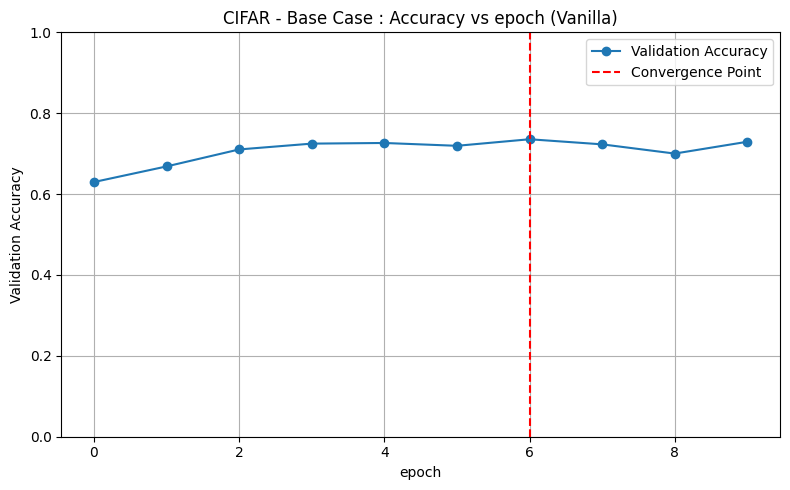

In [264]:
plot_validation_accuracy(
    range(n_epochs),
    stage_accs_vanilla,
    x_label="epoch",
    title="CIFAR - Base Case : Accuracy vs epoch (Vanilla)",
    convergence_epoch=convergence_idx)

### (1) Curriculum Learning

As curriculum learning is based on giving samples in increasing difficulty level to the model, we first need to define a difficulty function. We will base ours on difference between the distance of each point to the line that goes through all the data points.

#### Pre-analysis

In [3]:
def compute_cifar_difficulty(dataset):
    data_loader = DataLoader(dataset, batch_size=len(dataset))
    images, labels = next(iter(data_loader))
    images = images.view(images.size(0), -1)  # Flatten images

    centroids = [images[labels == i].mean(dim=0) for i in range(10)]
    difficulty = torch.tensor([
        torch.norm(img - centroids[label]).item()
        for img, label in zip(images, labels)
    ])
    return difficulty

#### Analysis

In [ ]:
num_stage_cl_vanilla = 5
difficulty = compute_cifar_difficulty(train_dataset).cpu().numpy()
difficulty = (difficulty - difficulty.min()) / (difficulty.max() - difficulty.min())
selector_meta_vanilla = {"difficulty": difficulty}

res_cl_vanilla = run_curriculum_training(
    SmallCNN,
    train_data,
    val_loader,
    test_loader,
    stage_selector_fn=difficulty_based_selector,
    selector_meta=selector_meta_vanilla,
    num_stages=num_stage_cl_vanilla,
    epochs_per_stage=10,
    batch_size=64,
    device="mps" if torch.backends.mps.is_available() else "cpu",
    lr=1e-3,
    epsilon=epsilon
)


Stage 1/5: Using 4500 samples
Epoch 1/10 - Train Loss: 1.3719 - Val Accuracy: 0.2880
Epoch 2/10 - Train Loss: 1.0744 - Val Accuracy: 0.3114
Epoch 3/10 - Train Loss: 0.9225 - Val Accuracy: 0.3470
Epoch 4/10 - Train Loss: 0.8084 - Val Accuracy: 0.3802
Epoch 5/10 - Train Loss: 0.7192 - Val Accuracy: 0.3878
Epoch 6/10 - Train Loss: 0.6345 - Val Accuracy: 0.4204
Epoch 7/10 - Train Loss: 0.5277 - Val Accuracy: 0.4206
Epoch 8/10 - Train Loss: 0.4416 - Val Accuracy: 0.4038
Epoch 9/10 - Train Loss: 0.3664 - Val Accuracy: 0.4208
Epoch 10/10 - Train Loss: 0.2624 - Val Accuracy: 0.4210

Stage 2/5: Using 10125 samples
Epoch 1/10 - Train Loss: 1.1160 - Val Accuracy: 0.5140
Epoch 2/10 - Train Loss: 0.8316 - Val Accuracy: 0.5312
Epoch 3/10 - Train Loss: 0.6688 - Val Accuracy: 0.5290
Epoch 4/10 - Train Loss: 0.5284 - Val Accuracy: 0.5490
Epoch 5/10 - Train Loss: 0.3940 - Val Accuracy: 0.5596
Epoch 6/10 - Train Loss: 0.2792 - Val Accuracy: 0.5502
Epoch 7/10 - Train Loss: 0.1844 - Val Accuracy: 0.5608
E

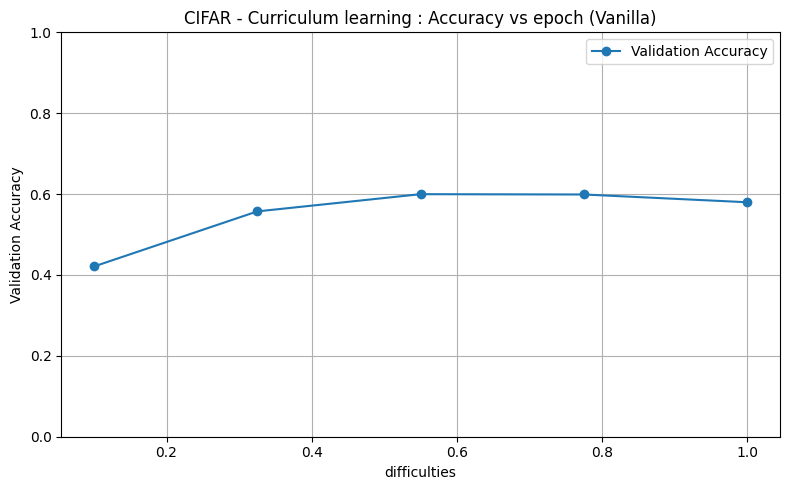

In [68]:
plot_validation_accuracy(
    np.linspace(0.1, 1.0, num_stage_cl_vanilla),
    res_cl_vanilla['val_accs'],
    x_label="difficulties",
    title="CIFAR - Curriculum learning : Accuracy vs epoch (Vanilla)",
    convergence_epoch=res_cl_vanilla["convergence_idx"])

### (2) Self-Paced Learning

In Self-Paced Learning, the model is supposed to:

• learn from easier samples first (based on current loss)

• adaptively expand its training set to include harder samples as it becomes more confident

We will use the same X_train, X_test, y_train and y_test computed in the curriculum learning phase.
To implement the SPL we will introduce a difficulty threshold to let the model choose how many samples of this difficulty it is ready to handle.

In [109]:
num_stage_spl_vanilla = 6
num_epochs_per_stage_spl_vanilla = 3

res_spl_vanilla = run_self_paced_training(
    SmallCNN,
    train_data,
    val_loader,
    test_loader,
    num_stages=num_stage_spl_vanilla,
    epochs_per_stage=num_epochs_per_stage_spl_vanilla,
    epsilon=epsilon,
    lambda_start=2.25,
    lambda_step=5,
    device="mps" if torch.backends.mps.is_available() else "cpu"
)

Stage 1/6 (lambda=2.2500): 11089/45000 samples selected
    Train Loss: 0.2965, Val Acc: 0.3538
Stage 2/6 (lambda=7.2500): 29170/45000 samples selected
    Train Loss: 0.5008, Val Acc: 0.5080
Stage 3/6 (lambda=12.2500): 43226/45000 samples selected
    Train Loss: 0.4165, Val Acc: 0.6988
Stage 4/6 (lambda=17.2500): 44997/45000 samples selected
    Train Loss: 0.1916, Val Acc: 0.7032
Stage 5/6 (lambda=22.2500): 44998/45000 samples selected
    Train Loss: 0.0930, Val Acc: 0.6956
Stage 6/6 (lambda=27.2500): 44998/45000 samples selected
    Train Loss: 0.0669, Val Acc: 0.6946

Final Test Accuracy: 0.6872


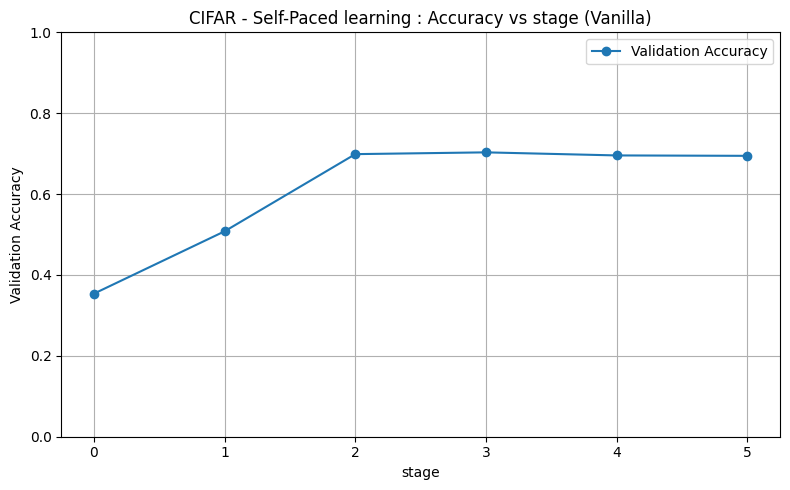

In [110]:
plot_validation_accuracy(
    range(num_stage_spl_vanilla),
    res_spl_vanilla["val_accs"],
    x_label="stage",
    title="CIFAR - Self-Paced learning : Accuracy vs stage (Vanilla)",
    convergence_epoch=res_cl_vanilla["convergence_idx"]
)

### (3) Hard-Example Mining

Hard-Example Mining consists in feeding the model only hard examples. In our case, we will consider that a sample is difficult if its normalized difficulty is greater or equal than 0,40 (in other words the top 60%). Because of the non-uniformity of difficulty we had to take such a high threshold to get a decent result

In [129]:
difficulty = compute_cifar_difficulty(train_dataset)
difficulty = (difficulty - difficulty.min()) / (difficulty.max() - difficulty.min())
selector_meta_vanilla = {"difficulty": difficulty}
difficulty_threshold = 0.4
num_epochs_hard_vanilla = 10

res_hard_vanilla = run_hard_example_training(
    SmallCNN,
    train_data,
    val_loader,
    test_loader,
    difficulty_based_hard_selector,
    selector_meta_vanilla,
    hard_threshold=difficulty_threshold,
    epochs=num_epochs_hard_vanilla,
    epsilon=epsilon,
    device="mps" if torch.backends.mps.is_available() else "cpu"
)


Using 17834 hard examples...
    Epoch 1/10 - Train Loss: 1.5810 - Val Accuracy: 0.4856
    Epoch 2/10 - Train Loss: 1.2022 - Val Accuracy: 0.5664
    Epoch 3/10 - Train Loss: 1.0008 - Val Accuracy: 0.5866
    Epoch 4/10 - Train Loss: 0.8594 - Val Accuracy: 0.5964
    Epoch 5/10 - Train Loss: 0.7278 - Val Accuracy: 0.6320
    Epoch 6/10 - Train Loss: 0.5992 - Val Accuracy: 0.5892
    Epoch 7/10 - Train Loss: 0.4783 - Val Accuracy: 0.6056
    Epoch 8/10 - Train Loss: 0.3696 - Val Accuracy: 0.6146
    Epoch 9/10 - Train Loss: 0.2774 - Val Accuracy: 0.6098
    Epoch 10/10 - Train Loss: 0.1896 - Val Accuracy: 0.6022

Final Test Accuracy: 0.5994


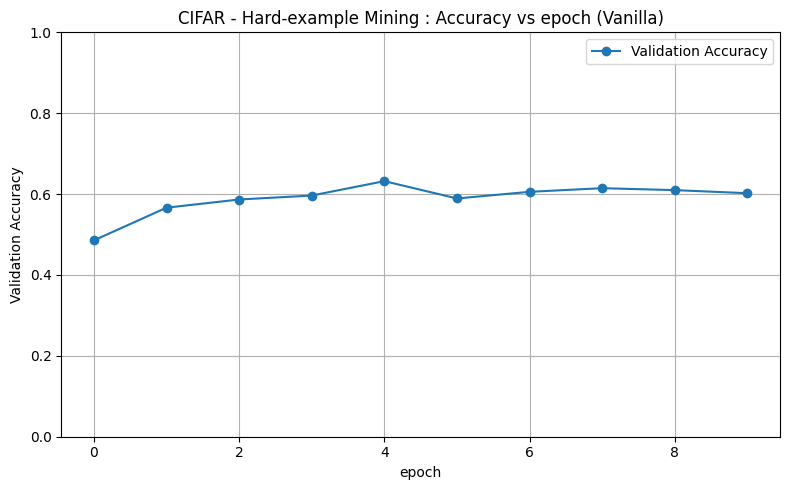

In [130]:
plot_validation_accuracy(
    range(num_epochs_hard_vanilla),
    res_hard_vanilla["val_accs"],
    x_label="epoch",
    title="CIFAR - Hard-example Mining : Accuracy vs epoch (Vanilla)",
    convergence_epoch=res_hard_vanilla["convergence_idx"])

### (4) Reverse Curriculum Learning

We are implementing **Reverse Curriculum Learning (RCL)** where the model starts learning from easier goals that are close to the target and gradually works backwards to more challenging starting states.

In [153]:
difficulty = compute_cifar_difficulty(train_dataset).cpu().numpy()

num_stage_rcl_vanilla = 5
num_epochs_per_stage_rcl_vanilla = 10

res_rcl_vanilla = run_reverse_curriculum_training(
    SmallCNN,
    train_data,
    val_loader,
    test_loader,
    stage_selector_fn=reverse_difficulty_based_selector,
    selector_meta={"difficulty": difficulty},
    num_stages=num_stage_rcl_vanilla,
    epochs_per_stage=num_epochs_per_stage_rcl_vanilla,
    epsilon=epsilon,
    device="mps" if torch.backends.mps.is_available() else "cpu"
)


Stage 1/5 (reverse): Using 10125 samples
    Epoch 1/10 - Train Loss: 1.4073
    Epoch 2/10 - Train Loss: 1.0544
    Epoch 3/10 - Train Loss: 0.9037
    Epoch 4/10 - Train Loss: 0.7838
    Epoch 5/10 - Train Loss: 0.6685
    Epoch 6/10 - Train Loss: 0.5639
    Epoch 7/10 - Train Loss: 0.4643
    Epoch 8/10 - Train Loss: 0.3605
    Epoch 9/10 - Train Loss: 0.2747
    Epoch 10/10 - Train Loss: 0.1819
Validation accuracy : 0.5306

Stage 2/5 (reverse): Using 10125 samples
    Epoch 1/10 - Train Loss: 1.1002
    Epoch 2/10 - Train Loss: 0.7489
    Epoch 3/10 - Train Loss: 0.5649
    Epoch 4/10 - Train Loss: 0.4115
    Epoch 5/10 - Train Loss: 0.2740
    Epoch 6/10 - Train Loss: 0.1697
    Epoch 7/10 - Train Loss: 0.0889
    Epoch 8/10 - Train Loss: 0.0399
    Epoch 9/10 - Train Loss: 0.0176
    Epoch 10/10 - Train Loss: 0.0086
Validation accuracy : 0.6126

Stage 3/5 (reverse): Using 10125 samples
    Epoch 1/10 - Train Loss: 1.2033
    Epoch 2/10 - Train Loss: 0.7262
    Epoch 3/10 - Train

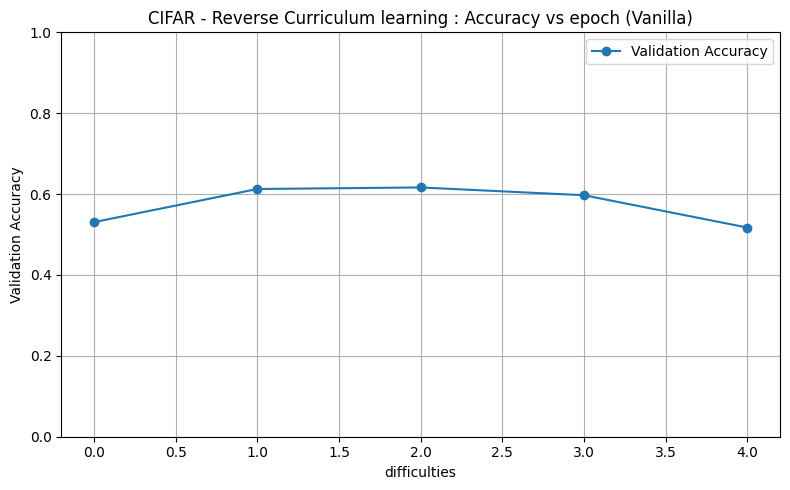

In [154]:
plot_validation_accuracy(
    range(num_stage_rcl_vanilla),
    res_rcl_vanilla['val_accs'],
    x_label="difficulties",
    title="CIFAR - Reverse Curriculum learning : Accuracy vs epoch (Vanilla)",
    convergence_epoch=res_rcl_vanilla["convergence_idx"])

### (5) Stratified Monte-Carlo Sampling

**Stratified Monte Carlo Sampling** is a variance reduction technique where the input space is divided into distinct strata (subregions), and samples are drawn from each stratum. This ensures more uniform coverage of the space compared to standard Monte Carlo sampling, leading to more accurate and stable estimates with fewer samples.

In [168]:
difficulties = compute_cifar_difficulty(train_dataset)
difficulties = (difficulties - difficulties.min()) / (difficulties.max() - difficulties.min())
num_stage_mcs_vanilla = 5
num_epochs_per_stage_smc_vanilla=10

res_mcs_vanilla = run_stratified_monte_carlo_training(
    SmallCNN,
    train_data,
    val_loader,
    test_loader,
    difficulties,
    num_stages=num_stage_mcs_vanilla,
    epochs_per_stage=num_epochs_per_stage_smc_vanilla,
    epsilon=epsilon,
    device="mps" if torch.backends.mps.is_available() else "cpu"
)


Stage 1/5: Sampling from stage level = 0
  Using 7435 samples for stage 1
    Epoch 1/10: Train Loss = 1.7952
    Epoch 2/10: Train Loss = 1.3635
    Epoch 3/10: Train Loss = 1.1539
    Epoch 4/10: Train Loss = 0.9888
    Epoch 5/10: Train Loss = 0.8415
    Epoch 6/10: Train Loss = 0.7065
    Epoch 7/10: Train Loss = 0.5671
    Epoch 8/10: Train Loss = 0.4376
    Epoch 9/10: Train Loss = 0.3335
    Epoch 10/10: Train Loss = 0.2350
  Validation Loss: 1.6484, Accuracy: 0.5828

Stage 2/5: Sampling from stage level = 1
  Using 6087 samples for stage 2
    Epoch 1/10: Train Loss = 1.1568
    Epoch 2/10: Train Loss = 0.7908
    Epoch 3/10: Train Loss = 0.5819
    Epoch 4/10: Train Loss = 0.4232
    Epoch 5/10: Train Loss = 0.2979
    Epoch 6/10: Train Loss = 0.1895
    Epoch 7/10: Train Loss = 0.1208
    Epoch 8/10: Train Loss = 0.0573
    Epoch 9/10: Train Loss = 0.0290
    Epoch 10/10: Train Loss = 0.0166
  Validation Loss: 1.9339, Accuracy: 0.6262

Stage 3/5: Sampling from stage level = 

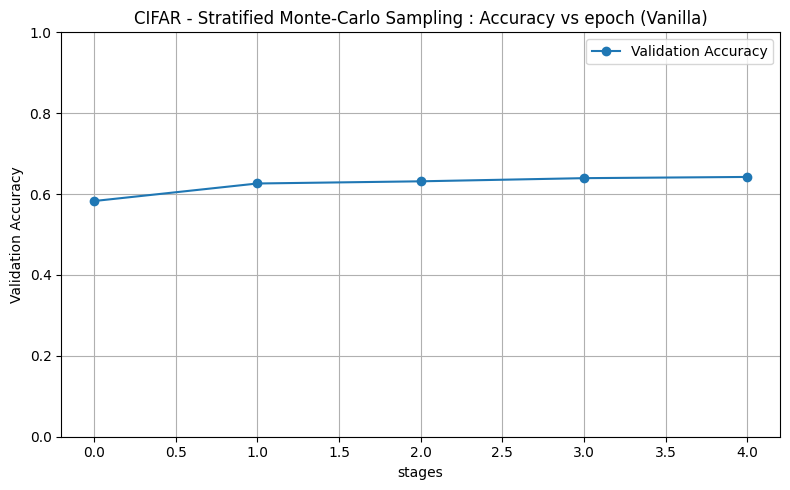

In [169]:
plot_validation_accuracy(
    range(num_stage_mcs_vanilla),
    res_mcs_vanilla['val_accs'],
    x_label="stages",
    title="CIFAR - Stratified Monte-Carlo Sampling : Accuracy vs epoch (Vanilla)",
    convergence_epoch=res_mcs_vanilla["convergence_idx"])

## Final Results

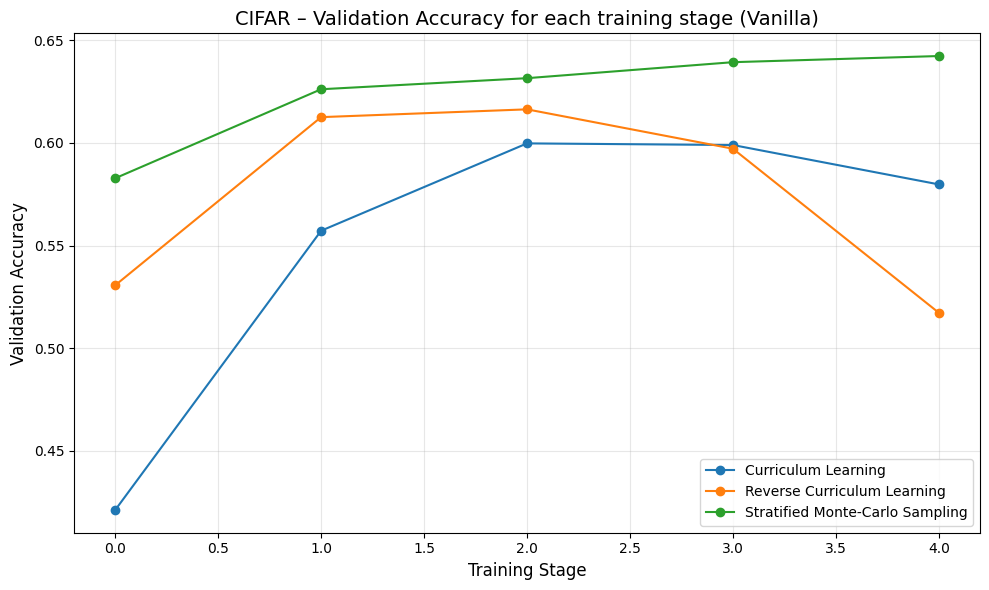

In [236]:
plot_multi_curves(
    range(5),
    res_cl_vanilla['val_accs'],
    res_rcl_vanilla['val_accs'],
    res_mcs_vanilla['val_accs'],
    labels=[
        "Curriculum Learning",
        "Reverse Curriculum Learning",
        "Stratified Monte-Carlo Sampling"
    ],
    title="CIFAR – Validation Accuracy for each training stage (Vanilla)",
    xlabel="Training Stage",
    ylabel="Validation Accuracy",
    markers=["o", "o", "o"],
    linestyles=["-", "-", "-"],
)

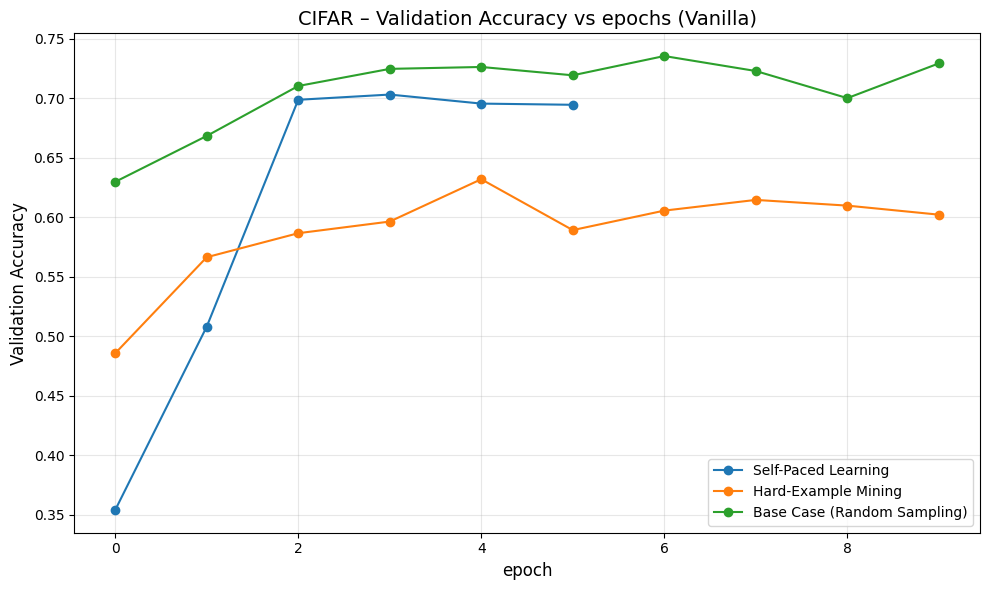

In [265]:
#hard-example,self-paced,base case
num_epochs=10
plot_multi_curves(
    range(num_epochs),
    pad_to_length(res_spl_vanilla['val_accs'], num_epochs),
    pad_to_length(res_hard_vanilla['val_accs'], num_epochs),
    pad_to_length(stage_accs_vanilla, num_epochs),
    labels=[
        "Self-Paced Learning",
        "Hard-Example Mining",
        "Base Case (Random Sampling)"
    ],
    title="CIFAR – Validation Accuracy vs epochs (Vanilla)",
    xlabel="epoch",
    ylabel="Validation Accuracy",
    markers=["o", "o", "o"],
    linestyles=["-", "-", "-"],
)

# CIFAR-10 Dataset with Gaussian Noise

## Data Loading

We initialize a range of increasing difficulty.
- 0.0: no noise — easiest samples
- 0.2: very noisy — hardest samples
- 0.25+ usually makes Cifar unreadable

In [266]:
transform = torchvision.transforms.ToTensor()
base_train = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
base_test  = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

full_data = torch.cat([torch.tensor(base_train.data), torch.tensor(base_test.data)], dim=0).float() / 255.0
full_targets = torch.cat([torch.tensor(base_train.targets), torch.tensor(base_test.targets)], dim=0)
full_data = full_data.permute(0, 3, 1, 2)  # (N, C, H, W)

num_total = full_data.shape[0]
train_val_indices, test_indices = train_test_split(torch.arange(num_total), test_size=0.2, random_state=42, stratify=full_targets)
train_indices, val_indices = train_test_split(train_val_indices, test_size=0.1, random_state=42, stratify=full_targets[train_val_indices])

splits = {
    "train": train_indices,
    "val": val_indices,
    "test": test_indices
}

noise_levels = [0.0, 0.05, 0.1, 0.15, 0.2]
sigma = 0.02

def apply_noise_to_split(indices, name):
    data = full_data[indices].clone()
    targets = full_targets[indices]
    N = len(data)

    samples_per_level = N // len(noise_levels)
    perm = torch.randperm(N)

    data_all, targets_all, noise_labels = [], [], []

    for i, level in enumerate(noise_levels):
        start = i * samples_per_level
        end = N if i == len(noise_levels) - 1 else start + samples_per_level
        idx = perm[start:end]
        d = data[idx].clone()
        t = targets[idx]

        if level > 0:
            C, H, W = d.shape[1:]
            total_pixels = H * W
            num_noisy = int(level * total_pixels)

            for j in range(d.shape[0]):
                coords = torch.randperm(total_pixels)[:num_noisy]
                flat_img = d[j].view(C, -1)
                flat_img[:, coords] += torch.randn(C, num_noisy) * sigma
                flat_img[:, coords].clamp_(0.0, 1.0)

        data_all.append(d)
        targets_all.append(t)
        noise_labels.append(torch.full_like(t, fill_value=i))

    return (
        torch.cat(data_all),
        torch.cat(targets_all),
        torch.cat(noise_labels)
    )

X_train, y_train, noise_levels_train = apply_noise_to_split(splits["train"], "train")
X_val, y_val, noise_levels_val = apply_noise_to_split(splits["val"], "val")
X_test, y_test, noise_levels_test = apply_noise_to_split(splits["test"], "test")

train_data = list(zip(X_train, y_train))

batch_size = 64

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) 

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


# Final dataset summary
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}, noise: {noise_levels_train.shape}")
print(f"X_val:   {X_val.shape}, y_val:   {y_val.shape}, noise: {noise_levels_val.shape}")
print(f"X_test:  {X_test.shape}, y_test:  {y_test.shape}, noise: {noise_levels_test.shape}")


Files already downloaded and verified
Files already downloaded and verified
X_train: torch.Size([43200, 3, 32, 32]), y_train: torch.Size([43200]), noise: torch.Size([43200])
X_val:   torch.Size([4800, 3, 32, 32]), y_val:   torch.Size([4800]), noise: torch.Size([4800])
X_test:  torch.Size([12000, 3, 32, 32]), y_test:  torch.Size([12000]), noise: torch.Size([12000])


## Analysis

### (0) Base Case

In [267]:
train_dataset_base = TensorDataset(X_train, y_train)
train_loader_base = DataLoader(train_dataset_base, batch_size=batch_size, shuffle=True) 

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

stage_accs_gaussian = []
val_loss = float('inf')
convergence_idx = -1
prev_val_loss = 0

epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss, total_correct = 0, 0

    for images, labels in train_loader_base:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()

    train_acc = total_correct / len(train_dataset_base)

    # VALIDATION
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            val_loss_total += loss.item() * images.size(0)

            predicted = outputs.argmax(dim=1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    
    prev_val_loss = val_loss
    val_loss = val_loss_total / val_total
    val_accuracy = val_correct / val_total
    stage_accs_gaussian.append(val_accuracy)
    if np.abs(val_loss - prev_val_loss) < epsilon:
        convergence_idx = epoch
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {total_loss/len(train_dataset_base):.4f} - Val Accuracy: {val_accuracy:.4f}")
        print(f"------------ The model has converged at epoch {epoch+1} ------------")
        break

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {total_loss/len(train_dataset_base):.4f} - Val Accuracy: {val_accuracy:.4f}")

model.eval()
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        correct += (outputs.argmax(1) == labels).sum().item()
test_acc = correct / len(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

Epoch 1/10 - Train Loss: 1.4926 - Val Accuracy: 0.5642
Epoch 2/10 - Train Loss: 1.1365 - Val Accuracy: 0.6273
Epoch 3/10 - Train Loss: 0.9737 - Val Accuracy: 0.6517
Epoch 4/10 - Train Loss: 0.8598 - Val Accuracy: 0.6867
Epoch 5/10 - Train Loss: 0.7711 - Val Accuracy: 0.6935
Epoch 6/10 - Train Loss: 0.6966 - Val Accuracy: 0.6885
Epoch 7/10 - Train Loss: 0.6215 - Val Accuracy: 0.7071
Epoch 8/10 - Train Loss: 0.5506 - Val Accuracy: 0.6996
Epoch 9/10 - Train Loss: 0.4881 - Val Accuracy: 0.7094
Epoch 10/10 - Train Loss: 0.4248 - Val Accuracy: 0.7142
Test Accuracy: 0.7126


ValueError: x and y must have same first dimension, but have shapes (0,) and (10,)

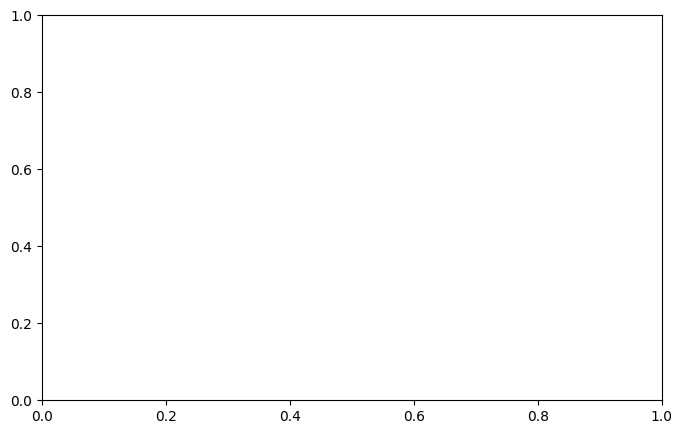

In [268]:
plot_validation_accuracy(
    range(convergence_idx+1),
    stage_accs_gaussian,
    x_label="epoch",
    title="CIFAR - Base Case : Accuracy vs epoch (Gaussian Noise)",
    convergence_epoch=convergence_idx)

### (1) Curriculum Learning

#### (1.1) Cumulative Curriculum Learning

In [193]:
selector_meta_cl_gaussian = {"noise_levels": noise_levels_train}

res_cum_cl_gaussian = run_curriculum_training(
    model_fn=SmallCNN,
    train_data=train_data,
    val_loader=val_loader,
    test_loader=test_loader,
    stage_selector_fn=noise_level_cum_selector,
    selector_meta=selector_meta_cl_gaussian,
    device=torch.device("mps" if torch.backends.mps.is_available() else "cpu"),
    epsilon=epsilon
)


Stage 1/5: Using 8640 samples
    Epoch 1/10 - Train Loss: 1.7435 - Val Accuracy: 0.1696
    Epoch 2/10 - Train Loss: 1.3413 - Val Accuracy: 0.1948
    Epoch 3/10 - Train Loss: 1.1609 - Val Accuracy: 0.1477
    Epoch 4/10 - Train Loss: 1.0155 - Val Accuracy: 0.1981
    Epoch 5/10 - Train Loss: 0.8764 - Val Accuracy: 0.2406
    Epoch 6/10 - Train Loss: 0.7553 - Val Accuracy: 0.2042
    Epoch 7/10 - Train Loss: 0.6412 - Val Accuracy: 0.2056
    Epoch 8/10 - Train Loss: 0.5267 - Val Accuracy: 0.1915
    Epoch 9/10 - Train Loss: 0.4049 - Val Accuracy: 0.1950
    Epoch 10/10 - Train Loss: 0.3274 - Val Accuracy: 0.2329

Stage 2/5: Using 17280 samples
    Epoch 1/10 - Train Loss: 0.7940 - Val Accuracy: 0.1621
    Epoch 2/10 - Train Loss: 0.6009 - Val Accuracy: 0.1700
    Epoch 3/10 - Train Loss: 0.4698 - Val Accuracy: 0.1860
    Epoch 4/10 - Train Loss: 0.3627 - Val Accuracy: 0.1613
    Epoch 5/10 - Train Loss: 0.2582 - Val Accuracy: 0.2060
    Epoch 6/10 - Train Loss: 0.1845 - Val Accuracy:

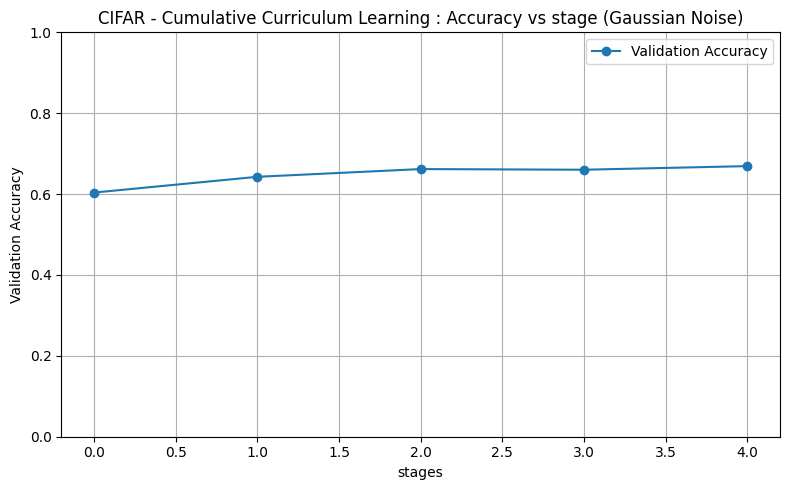

In [84]:
plot_validation_accuracy(
    range(len(noise_levels)),
    res_cum_cl_gaussian['val_accs'],
    x_label="stages",
    title="CIFAR - Cumulative Curriculum Learning : Accuracy vs stage (Gaussian Noise)",
    convergence_epoch=res_cum_cl_gaussian["convergence_idx"])

#### (1.2) Strict Curriculum Learning

In [86]:
res_strict_cl_gaussian = run_curriculum_training(
    model_fn=SmallCNN,
    train_data=train_data,
    val_loader=val_loader,
    test_loader=test_loader,
    stage_selector_fn=noise_level_strict_selector,
    selector_meta=selector_meta_cl_gaussian,
    device=torch.device("mps" if torch.backends.mps.is_available() else "cpu"),
    epsilon=epsilon
)


Stage 1/5: Using 8640 samples
Epoch 1/10 - Train Loss: 1.9204 - Val Accuracy: 0.4069
Epoch 2/10 - Train Loss: 1.5305 - Val Accuracy: 0.4708
Epoch 3/10 - Train Loss: 1.3894 - Val Accuracy: 0.4992
Epoch 4/10 - Train Loss: 1.2852 - Val Accuracy: 0.5273
Epoch 5/10 - Train Loss: 1.1959 - Val Accuracy: 0.5342
Epoch 6/10 - Train Loss: 1.1373 - Val Accuracy: 0.5454
Epoch 7/10 - Train Loss: 1.0622 - Val Accuracy: 0.5669
Epoch 8/10 - Train Loss: 0.9918 - Val Accuracy: 0.5694
Epoch 9/10 - Train Loss: 0.9330 - Val Accuracy: 0.5683
Epoch 10/10 - Train Loss: 0.8492 - Val Accuracy: 0.5690

Stage 2/5: Using 8640 samples
Epoch 1/10 - Train Loss: 1.2083 - Val Accuracy: 0.5965
Epoch 2/10 - Train Loss: 1.0670 - Val Accuracy: 0.6110
Epoch 3/10 - Train Loss: 0.9832 - Val Accuracy: 0.6110
Epoch 4/10 - Train Loss: 0.8936 - Val Accuracy: 0.6212
Epoch 5/10 - Train Loss: 0.8180 - Val Accuracy: 0.6131
Epoch 6/10 - Train Loss: 0.7393 - Val Accuracy: 0.6083
Epoch 7/10 - Train Loss: 0.6703 - Val Accuracy: 0.6260
Ep

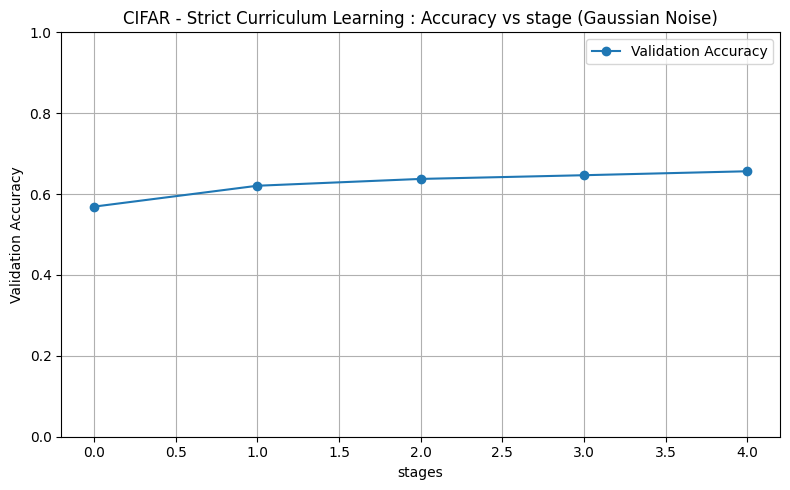

In [87]:
plot_validation_accuracy(
    range(len(noise_levels)),
    res_strict_cl_gaussian['val_accs'],
    x_label="stages",
    title="CIFAR - Strict Curriculum Learning : Accuracy vs stage (Gaussian Noise)",
    convergence_epoch=res_strict_cl_gaussian["convergence_idx"])

### (2) Self-Paced Learning

In [114]:
num_stage_spl_gaussian = 6
num_epochs_per_stage_spl_gaussian = 3

res_spl_gaussian = run_self_paced_training(
    SmallCNN,
    train_data,
    val_loader,
    test_loader,
    num_stages=num_stage_spl_gaussian,
    epochs_per_stage=num_epochs_per_stage_spl_gaussian,
    lambda_start = 2.25,
    lambda_step = 5,
    epsilon=epsilon,
    device="mps" if torch.backends.mps.is_available() else "cpu"
)

Stage 1/6 (lambda=2.2500): 8227/43200 samples selected
    Train Loss: 0.2291, Val Acc: 0.1894
Stage 2/6 (lambda=7.2500): 11955/43200 samples selected
    Train Loss: 0.2022, Val Acc: 0.2767
Stage 3/6 (lambda=12.2500): 17932/43200 samples selected
    Train Loss: 0.3265, Val Acc: 0.3577
Stage 4/6 (lambda=17.2500): 39678/43200 samples selected
    Train Loss: 0.6526, Val Acc: 0.6735
Stage 5/6 (lambda=22.2500): 43197/43200 samples selected
    Train Loss: 0.4941, Val Acc: 0.7048
Stage 6/6 (lambda=27.2500): 43199/43200 samples selected
    Train Loss: 0.3029, Val Acc: 0.7067

Final Test Accuracy: 0.6946


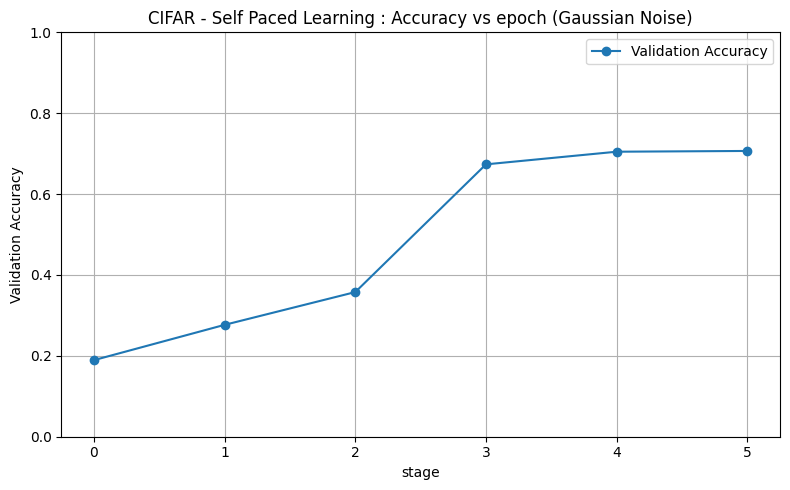

In [115]:
plot_validation_accuracy(
    range(num_stage_spl_gaussian),
    res_spl_gaussian["val_accs"],
    x_label="stage",
    title="CIFAR - Self Paced Learning : Accuracy vs epoch (Gaussian Noise)",
    convergence_epoch=res_spl_gaussian["convergence_idx"])

### (3) Hard-Example Mining

In [132]:
selector_meta_hard_gaussian = {"noise_levels": noise_levels_train}
num_epochs_hard_gaussian = 10

res_hard_gaussian = run_hard_example_training(
    SmallCNN,
    train_data,
    val_loader,
    test_loader,
    noise_level_hard_selector,
    selector_meta_hard_gaussian,
    hard_threshold=3,
    epochs=num_epochs_hard_gaussian,
    epsilon=epsilon,
    device="mps" if torch.backends.mps.is_available() else "cpu"
)


Using 17280 hard examples...
    Epoch 1/10 - Train Loss: 1.7521 - Val Accuracy: 0.4708
    Epoch 2/10 - Train Loss: 1.3568 - Val Accuracy: 0.5479
    Epoch 3/10 - Train Loss: 1.1955 - Val Accuracy: 0.5652
    Epoch 4/10 - Train Loss: 1.0908 - Val Accuracy: 0.5998
    Epoch 5/10 - Train Loss: 0.9938 - Val Accuracy: 0.6127
    Epoch 6/10 - Train Loss: 0.9064 - Val Accuracy: 0.6262
    Epoch 7/10 - Train Loss: 0.8399 - Val Accuracy: 0.6338
    Epoch 8/10 - Train Loss: 0.7709 - Val Accuracy: 0.6490
    Epoch 9/10 - Train Loss: 0.6956 - Val Accuracy: 0.6348
    Epoch 10/10 - Train Loss: 0.6363 - Val Accuracy: 0.6344

Final Test Accuracy: 0.6348


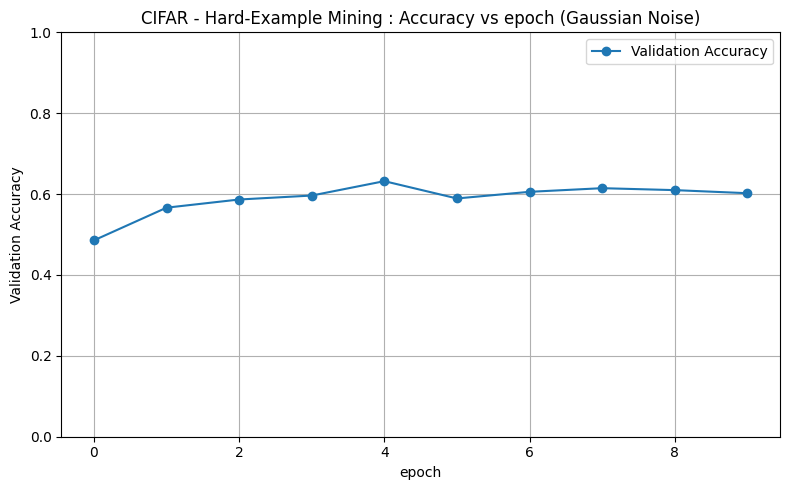

In [133]:
plot_validation_accuracy(
    range(num_epochs_hard_gaussian),
    res_hard_vanilla["val_accs"],
    x_label="epoch",
    title="CIFAR - Hard-Example Mining : Accuracy vs epoch (Gaussian Noise)",
    convergence_epoch=res_hard_vanilla["convergence_idx"])

### (4) Reverse Curriculum Learning

#### (4.1) Cumulative Reverse Curriculum Learning

In [ ]:
num_stage_rcl_cum_gaussian = 5
num_epochs_per_stage_rcl_cum_gaussian = 10

res_cum_rcl_gaussian = run_reverse_curriculum_training(
    SmallCNN,
    train_data,
    val_loader,
    test_loader,
    stage_selector_fn=reverse_noise_level_cum_selector,
    selector_meta={"noise_levels": noise_levels_train},
    num_stages=num_stage_rcl_cum_gaussian,
    epochs_per_stage=num_epochs_per_stage_rcl_cum_gaussian,
    device="mps" if torch.backends.mps.is_available() else "cpu",
    epsilon=epsilon
)


Stage 1/5 (reverse): Using 8640 samples
    Epoch 1/10 - Train Loss: 1.8920
    Epoch 2/10 - Train Loss: 1.5292
    Epoch 3/10 - Train Loss: 1.3755
    Epoch 4/10 - Train Loss: 1.2839
    Epoch 5/10 - Train Loss: 1.1795
    Epoch 6/10 - Train Loss: 1.0924
    Epoch 7/10 - Train Loss: 1.0220
    Epoch 8/10 - Train Loss: 0.9429
    Epoch 9/10 - Train Loss: 0.8707
    Epoch 10/10 - Train Loss: 0.7895
Validation accuracy for epoch 10/10: 0.5835416666666666

Stage 2/5 (reverse): Using 17280 samples
    Epoch 1/10 - Train Loss: 0.9751
    Epoch 2/10 - Train Loss: 0.8770
    Epoch 3/10 - Train Loss: 0.7979
    Epoch 4/10 - Train Loss: 0.7189
    Epoch 5/10 - Train Loss: 0.6526
    Epoch 6/10 - Train Loss: 0.5818
    Epoch 7/10 - Train Loss: 0.5182
    Epoch 8/10 - Train Loss: 0.4470
    Epoch 9/10 - Train Loss: 0.3797
    Epoch 10/10 - Train Loss: 0.3191
Validation accuracy for epoch 10/10: 0.6308333333333334

Stage 3/5 (reverse): Using 25920 samples
    Epoch 1/10 - Train Loss: 0.6473
    E

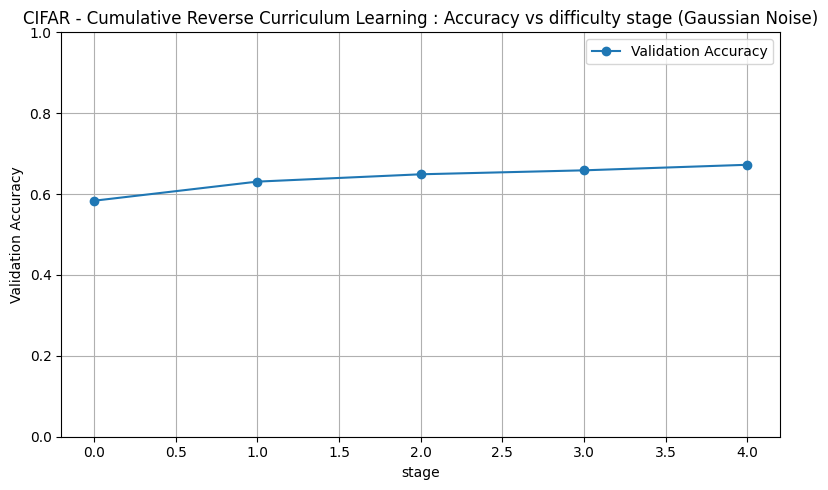

In [ ]:
plot_validation_accuracy(
    list(range(num_stage_rcl_cum_gaussian)),
    res_cum_rcl_gaussian["val_accs"],
    x_label="stage",
    title="CIFAR - Cumulative Reverse Curriculum Learning : Accuracy vs difficulty stage (Gaussian Noise)",
    convergence_epoch=res_cum_rcl_gaussian["convergence_idx"])

#### (4.2) Strict Reverse Curriculum Learning

In [144]:
num_stage_strict_rcl_gaussian = 5
num_epochs_per_stage_strict_rcl_gaussian = 10

res_strict_rcl_gaussian = run_reverse_curriculum_training(
    SmallCNN,
    train_data,
    val_loader,
    test_loader,
    stage_selector_fn=noise_level_strict_selector,
    selector_meta={"noise_levels": noise_levels_train},
    num_stages=num_stage_strict_rcl_gaussian,
    epochs_per_stage=num_epochs_per_stage_strict_rcl_gaussian,
    device="mps" if torch.backends.mps.is_available() else "cpu",
    epsilon=epsilon
)


Stage 1/5 (reverse): Using 8640 samples
    Epoch 1/10 - Train Loss: 1.9029
    Epoch 2/10 - Train Loss: 1.5232
    Epoch 3/10 - Train Loss: 1.3666
    Epoch 4/10 - Train Loss: 1.2595
    Epoch 5/10 - Train Loss: 1.1736
    Epoch 6/10 - Train Loss: 1.0870
    Epoch 7/10 - Train Loss: 1.0201
    Epoch 8/10 - Train Loss: 0.9540
    Epoch 9/10 - Train Loss: 0.8722
    Epoch 10/10 - Train Loss: 0.8041
Validation accuracy : 0.6077

Stage 2/5 (reverse): Using 8640 samples
    Epoch 1/10 - Train Loss: 1.1649
    Epoch 2/10 - Train Loss: 1.0332
    Epoch 3/10 - Train Loss: 0.9245
    Epoch 4/10 - Train Loss: 0.8624
    Epoch 5/10 - Train Loss: 0.7832
    Epoch 6/10 - Train Loss: 0.7113
    Epoch 7/10 - Train Loss: 0.6348
    Epoch 8/10 - Train Loss: 0.5759
    Epoch 9/10 - Train Loss: 0.4910
    Epoch 10/10 - Train Loss: 0.4273
Validation accuracy : 0.6269

Stage 3/5 (reverse): Using 8640 samples
    Epoch 1/10 - Train Loss: 1.0943
    Epoch 2/10 - Train Loss: 0.8788
    Epoch 3/10 - Train Lo

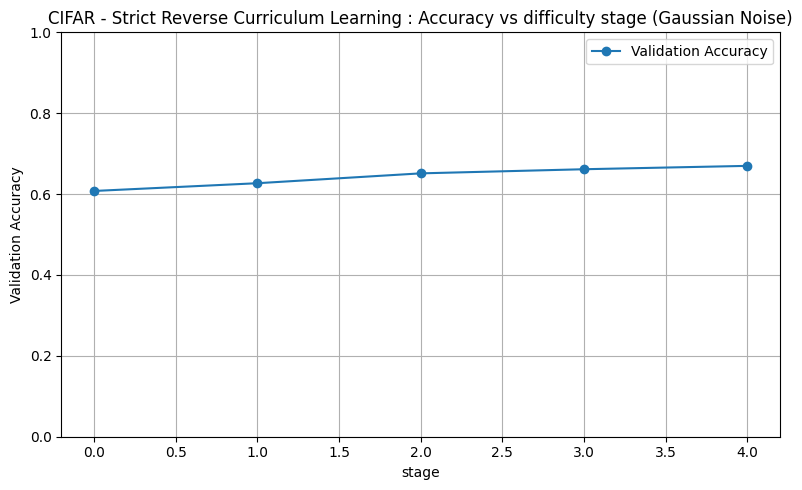

In [145]:
plot_validation_accuracy(
    list(range(num_stage_strict_rcl_gaussian)),
    res_strict_rcl_gaussian["val_accs"],
    x_label="stage",
    title="CIFAR - Strict Reverse Curriculum Learning : Accuracy vs difficulty stage (Gaussian Noise)",
    convergence_epoch=res_strict_rcl_gaussian["convergence_idx"])

### (5) Stratified Monte-Carlo Sampling

**Stratified Monte Carlo Sampling** is a variance reduction technique where the input space is divided into distinct strata (subregions), and samples are drawn from each stratum. This ensures more uniform coverage of the space compared to standard Monte Carlo sampling, leading to more accurate and stable estimates with fewer samples.

In [ ]:
difficulties = compute_cifar_difficulty(train_dataset)
num_stage_mcs_vanilla = 5

res_mcs_vanilla = run_stratified_monte_carlo_training(
    SmallCNN,
    train_data,
    val_loader,
    test_loader,
    difficulties,
    num_stages=num_stage_mcs_vanilla,
    epochs_per_stage=10,
    batch_size=64,
    lr=1e-3,
    epsilon=epsilon,
    device="mps" if torch.backends.mps.is_available() else "cpu"
)

In [157]:
num_stages_smc_gaussian = 5
num_epochs_per_stage_smc_gaussian = 10

res_smc_gaussian = run_stratified_monte_carlo_training(
    SmallCNN,
    train_data,
    val_loader,
    test_loader,
    noise_levels_train,
    num_stages=num_stages_smc_gaussian,
    epochs_per_stage=num_epochs_per_stage_smc_gaussian,
    epsilon=epsilon,
    device="mps" if torch.backends.mps.is_available() else "cpu",
)


Stage 1/5: Sampling from stage level = 0
  Using 3456 samples for stage 1
    Epoch 1/10: Train Loss = 2.1181
    Epoch 2/10: Train Loss = 1.8037
    Epoch 3/10: Train Loss = 1.6191
    Epoch 4/10: Train Loss = 1.5392
    Epoch 5/10: Train Loss = 1.4253
    Epoch 6/10: Train Loss = 1.3559
    Epoch 7/10: Train Loss = 1.2853
    Epoch 8/10: Train Loss = 1.2105
    Epoch 9/10: Train Loss = 1.1423
    Epoch 10/10: Train Loss = 1.0715
  Validation Loss: 1.3749, Accuracy: 0.5085

Stage 2/5: Sampling from stage level = 1
  Using 3456 samples for stage 2
    Epoch 1/10: Train Loss = 1.3453
    Epoch 2/10: Train Loss = 1.2348
    Epoch 3/10: Train Loss = 1.1399
    Epoch 4/10: Train Loss = 1.0725
    Epoch 5/10: Train Loss = 0.9928
    Epoch 6/10: Train Loss = 0.9197
    Epoch 7/10: Train Loss = 0.8335
    Epoch 8/10: Train Loss = 0.7834
    Epoch 9/10: Train Loss = 0.7129
    Epoch 10/10: Train Loss = 0.6307
  Validation Loss: 1.3626, Accuracy: 0.5560

Stage 3/5: Sampling from stage level = 

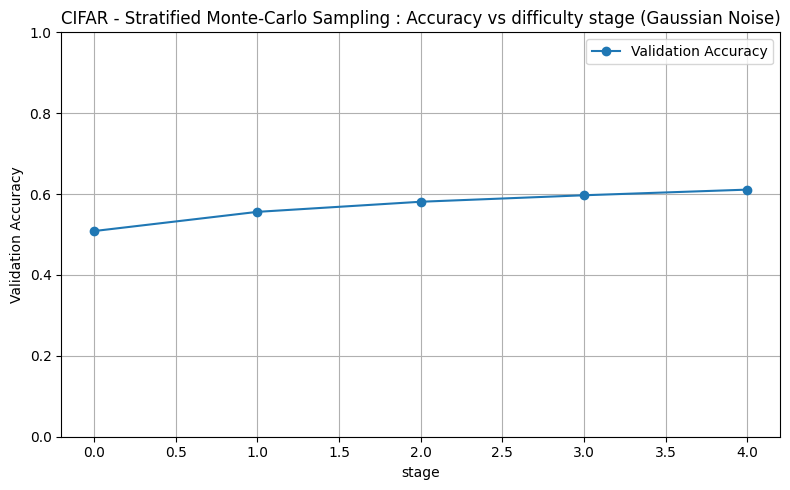

In [158]:
plot_validation_accuracy(
    range(num_stages_smc_gaussian),
    res_smc_gaussian["val_accs"],
    x_label="stage",
    title="CIFAR - Stratified Monte-Carlo Sampling : Accuracy vs difficulty stage (Gaussian Noise)",
    convergence_epoch=res_smc_gaussian["convergence_idx"])

## Final Results

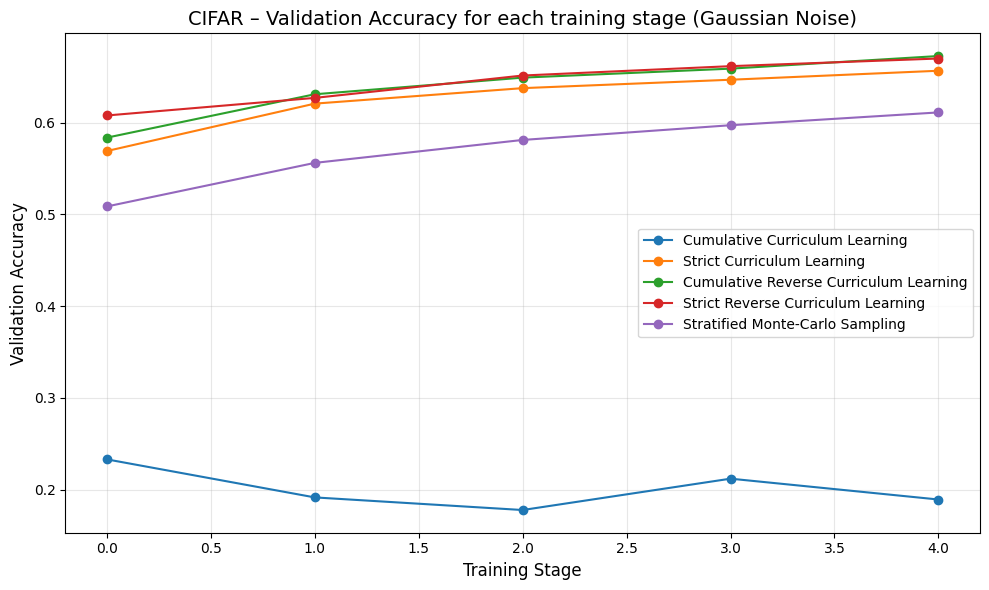

In [235]:
plot_multi_curves(
    range(5),
    res_cum_cl_gaussian['val_accs'],
    res_strict_cl_gaussian['val_accs'],
    res_cum_rcl_gaussian['val_accs'],
    res_strict_rcl_gaussian['val_accs'],
    res_smc_gaussian['val_accs'],
    labels=[
        "Cumulative Curriculum Learning",
        "Strict Curriculum Learning",
        "Cumulative Reverse Curriculum Learning",
        "Strict Reverse Curriculum Learning",
        "Stratified Monte-Carlo Sampling"
    ],
    title="CIFAR – Validation Accuracy for each training stage (Gaussian Noise)",
    xlabel="Training Stage",
    ylabel="Validation Accuracy",
    markers=["o", "o", "o", "o", "o"],
    linestyles=["-", "-", "-", "-", "-"],
)

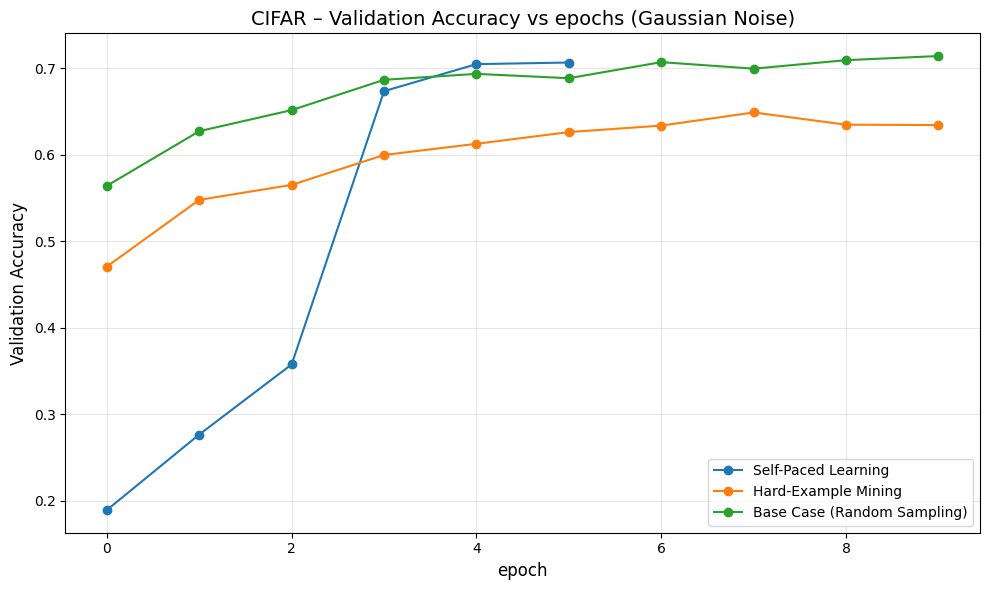

In [269]:
#hard-example,self-paced,base case
num_epochs=10
plot_multi_curves(
    range(num_epochs),
    pad_to_length(res_spl_gaussian['val_accs'], num_epochs),
    pad_to_length(res_hard_gaussian['val_accs'], num_epochs),
    pad_to_length(stage_accs_gaussian, num_epochs),
    labels=[
        "Self-Paced Learning",
        "Hard-Example Mining",
        "Base Case (Random Sampling)"
    ],
    title="CIFAR – Validation Accuracy vs epochs (Gaussian Noise)",
    xlabel="epoch",
    ylabel="Validation Accuracy",
    markers=["o", "o", "o"],
    linestyles=["-", "-", "-"],
)

# CIFAR-10 Dataset with Impulse Noise

## Data Loading

We initialize a range of increasing difficulty.
- 0.0: no noise — easiest samples
- 0.2: very noisy — hardest samples
- 0.25+ usually makes Cifar unreadable

In [270]:
transform = transforms.ToTensor()

base_train = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
base_test  = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

full_data = torch.cat([torch.tensor(base_train.data), torch.tensor(base_test.data)], dim=0).float() / 255.0
full_targets = torch.cat([torch.tensor(base_train.targets), torch.tensor(base_test.targets)], dim=0)
full_data = full_data.permute(0, 3, 1, 2)  # (N, C, H, W)

num_total = full_data.shape[0]
train_val_indices, test_indices = train_test_split(
    torch.arange(num_total), test_size=0.2, random_state=42, stratify=full_targets
)
train_indices, val_indices = train_test_split(
    train_val_indices, test_size=0.1, random_state=42, stratify=full_targets[train_val_indices]
)

splits = {
    "train": train_indices,
    "val": val_indices,
    "test": test_indices
}

noise_levels = [0.0, 0.05, 0.1, 0.15, 0.2]

def apply_impulse_noise_to_split(indices, name):
    data = full_data[indices].clone()
    targets = full_targets[indices]
    N = len(data)

    samples_per_level = N // len(noise_levels)
    perm = torch.randperm(N)

    data_all, targets_all, noise_labels = [], [], []

    for i, level in enumerate(noise_levels):
        start = i * samples_per_level
        end = N if i == len(noise_levels) - 1 else start + samples_per_level
        idx = perm[start:end]
        d = data[idx].clone()
        t = targets[idx]

        if level > 0:
            C, H, W = d.shape[1:]
            total_pixels = H * W
            num_noisy = int(level * total_pixels)

            for j in range(d.shape[0]):
                coords = torch.randperm(total_pixels)[:num_noisy]
                flat_img = d[j].view(C, -1)
                # Impulse noise: set random pixels to 0 or 1
                flat_img[:, coords] = torch.randint(0, 2, (C, num_noisy), dtype=torch.float32)
                flat_img[:, coords].clamp_(0.0, 1.0)

        data_all.append(d)
        targets_all.append(t)
        noise_labels.append(torch.full_like(t, fill_value=i))

    return (
        torch.cat(data_all),
        torch.cat(targets_all),
        torch.cat(noise_labels)
    )

X_train, y_train, noise_levels_train = apply_impulse_noise_to_split(splits["train"], "train")
X_val, y_val, noise_levels_val = apply_impulse_noise_to_split(splits["val"], "val")
X_test, y_test, noise_levels_test = apply_impulse_noise_to_split(splits["test"], "test")

train_data = list(zip(X_train, y_train))

batch_size = 64

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=False)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

# --- Print dataset summaries ---
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}, noise: {noise_levels_train.shape}")
print(f"X_val:   {X_val.shape}, y_val:   {y_val.shape}, noise: {noise_levels_val.shape}")
print(f"X_test:  {X_test.shape}, y_test:  {y_test.shape}, noise: {noise_levels_test.shape}")


Files already downloaded and verified
Files already downloaded and verified
X_train: torch.Size([43200, 3, 32, 32]), y_train: torch.Size([43200]), noise: torch.Size([43200])
X_val:   torch.Size([4800, 3, 32, 32]), y_val:   torch.Size([4800]), noise: torch.Size([4800])
X_test:  torch.Size([12000, 3, 32, 32]), y_test:  torch.Size([12000]), noise: torch.Size([12000])


## Analysis

### (0) Base Case

In [271]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 10
stage_accs_impulse = []
val_loss = 0
convergence_idx = -1

for epoch in range(epochs):
    model.train()
    total_loss, total_correct = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()

    train_acc = total_correct / len(train_dataset)

    # VALIDATION
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            val_loss_total += loss.item() * images.size(0)

            predicted = outputs.argmax(dim=1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    if epoch > 0:
        if np.abs(val_loss - (val_loss_total/val_total)) < epsilon:
            convergence_idx = epoch
            val_loss = val_loss_total / val_total
            val_accuracy = val_correct / val_total
            stage_accs_impulse.append(val_accuracy)
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {total_loss/len(train_dataset):.4f} - Val Accuracy: {val_accuracy:.4f}")
            print(f"------------ The model has converged at epoch {epoch+1} ------------")
            break

    val_loss = val_loss_total / val_total
    val_accuracy = val_correct / val_total

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {total_loss/len(train_dataset):.4f} - Val Accuracy: {val_accuracy:.4f}")
    stage_accs_impulse.append(val_accuracy)

model.eval()
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        correct += (outputs.argmax(1) == labels).sum().item()
test_acc = correct / len(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

Epoch 1/10 - Train Loss: 1.6789 - Val Accuracy: 0.4427
Epoch 2/10 - Train Loss: 1.3661 - Val Accuracy: 0.5073
Epoch 3/10 - Train Loss: 1.2338 - Val Accuracy: 0.5285
Epoch 4/10 - Train Loss: 1.1412 - Val Accuracy: 0.5390
Epoch 5/10 - Train Loss: 1.0669 - Val Accuracy: 0.5569
Epoch 6/10 - Train Loss: 0.9970 - Val Accuracy: 0.5652
Epoch 7/10 - Train Loss: 0.9326 - Val Accuracy: 0.5646
Epoch 8/10 - Train Loss: 0.8714 - Val Accuracy: 0.5563
Epoch 9/10 - Train Loss: 0.8150 - Val Accuracy: 0.5577
Epoch 10/10 - Train Loss: 0.7602 - Val Accuracy: 0.5569
Test Accuracy: 0.5559


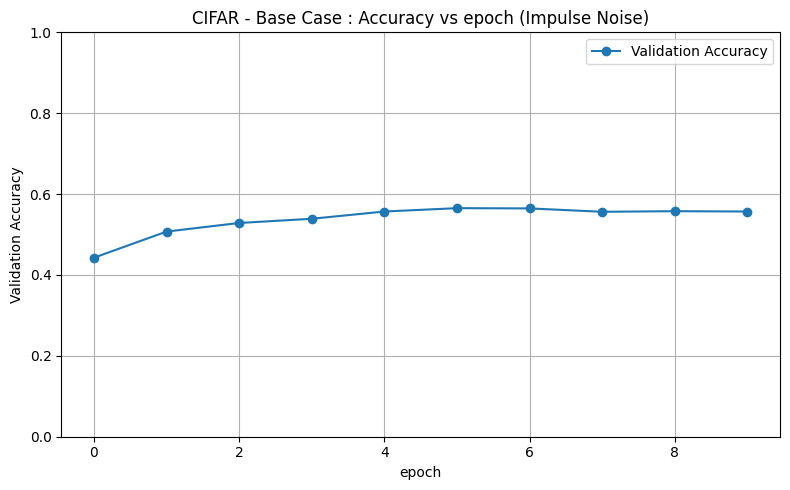

In [272]:
plot_validation_accuracy(
    range(len(stage_accs_impulse)),
    stage_accs_impulse,
    x_label="epoch",
    title="CIFAR - Base Case : Accuracy vs epoch (Impulse Noise)",
    convergence_epoch=convergence_idx)

### (1) Curriculum Learning

#### (1.1) Cumulative Curriculum Learning

In [209]:
selector_meta_cl_impulse = {"noise_levels": noise_levels_train}
num_stages_cl_impulse = 5
num_epochs_per_stage_cl_impulse = 10

res_cum_cl_impulse = run_curriculum_training(
    model_fn=SmallCNN,
    train_data=train_data,
    val_loader=val_loader,
    test_loader=test_loader,
    stage_selector_fn=noise_level_cum_selector,
    selector_meta=selector_meta_cl_impulse,
    num_stages=num_stages_cl_impulse,
    epochs_per_stage=num_epochs_per_stage_cl_impulse,
    device=torch.device("mps" if torch.backends.mps.is_available() else "cpu"),
    epsilon=epsilon,
)


Stage 1/5: Using 8640 samples
    Epoch 1/10 - Train Loss: 1.8976 - Val Accuracy: 0.3000
    Epoch 2/10 - Train Loss: 1.5118 - Val Accuracy: 0.3435
    Epoch 3/10 - Train Loss: 1.3726 - Val Accuracy: 0.3158
    Epoch 4/10 - Train Loss: 1.2586 - Val Accuracy: 0.3535
    Epoch 5/10 - Train Loss: 1.1504 - Val Accuracy: 0.3565
    Epoch 6/10 - Train Loss: 1.0714 - Val Accuracy: 0.3496
    Epoch 7/10 - Train Loss: 0.9956 - Val Accuracy: 0.3619
    Epoch 8/10 - Train Loss: 0.9254 - Val Accuracy: 0.3700
    Epoch 9/10 - Train Loss: 0.8362 - Val Accuracy: 0.2885
    Epoch 10/10 - Train Loss: 0.7532 - Val Accuracy: 0.3585

Stage 2/5: Using 17280 samples
    Epoch 1/10 - Train Loss: 1.0268 - Val Accuracy: 0.5115
    Epoch 2/10 - Train Loss: 0.8985 - Val Accuracy: 0.5188
    Epoch 3/10 - Train Loss: 0.8110 - Val Accuracy: 0.5300
    Epoch 4/10 - Train Loss: 0.7169 - Val Accuracy: 0.5460
    Epoch 5/10 - Train Loss: 0.6168 - Val Accuracy: 0.5427
    Epoch 6/10 - Train Loss: 0.5316 - Val Accuracy:

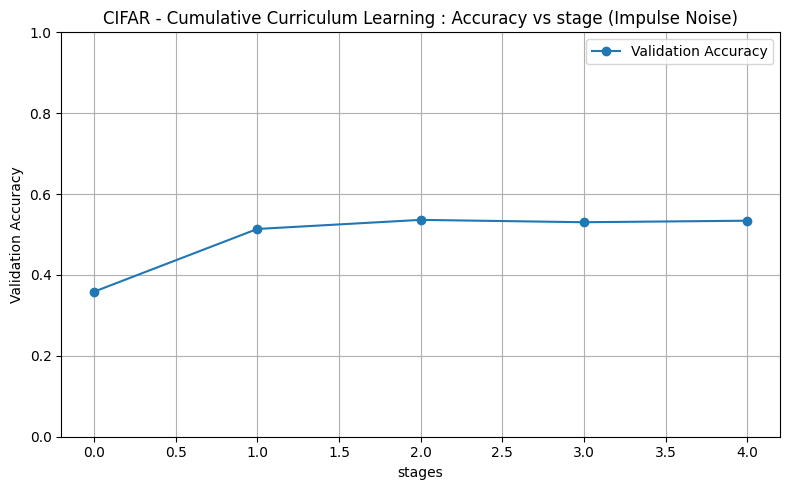

In [210]:
plot_validation_accuracy(
    range(num_stages_cl_impulse),
    res_cum_cl_impulse['val_accs'],
    x_label="stages",
    title="CIFAR - Cumulative Curriculum Learning : Accuracy vs stage (Impulse Noise)",
    convergence_epoch=res_cum_cl_impulse["convergence_idx"])

#### (1.2) Strict Curriculum Learning

In [211]:
num_stages_strict_cl_impulse = 5
num_epochs_per_stage_strict_cl_impulse = 10

res_strict_cl_impulse = run_curriculum_training(
    model_fn=SmallCNN,
    train_data=train_data,
    val_loader=val_loader,
    test_loader=test_loader,
    stage_selector_fn=noise_level_strict_selector,
    selector_meta=selector_meta_cl_impulse,
    num_stages=num_stages_strict_cl_impulse,
    epochs_per_stage=num_epochs_per_stage_strict_cl_impulse,
    device=torch.device("mps" if torch.backends.mps.is_available() else "cpu"),
    epsilon=epsilon
)


Stage 1/5: Using 8640 samples
    Epoch 1/10 - Train Loss: 1.9213 - Val Accuracy: 0.2565
    Epoch 2/10 - Train Loss: 1.5466 - Val Accuracy: 0.2583
    Epoch 3/10 - Train Loss: 1.3969 - Val Accuracy: 0.3925
    Epoch 4/10 - Train Loss: 1.2904 - Val Accuracy: 0.4071
    Epoch 5/10 - Train Loss: 1.1944 - Val Accuracy: 0.4117
    Epoch 6/10 - Train Loss: 1.1109 - Val Accuracy: 0.3631
    Epoch 7/10 - Train Loss: 1.0388 - Val Accuracy: 0.4123
    Epoch 8/10 - Train Loss: 0.9818 - Val Accuracy: 0.4027
    Epoch 9/10 - Train Loss: 0.9040 - Val Accuracy: 0.4069
    Epoch 10/10 - Train Loss: 0.8458 - Val Accuracy: 0.3935

Stage 2/5: Using 8640 samples
    Epoch 1/10 - Train Loss: 1.2858 - Val Accuracy: 0.4775
    Epoch 2/10 - Train Loss: 1.1315 - Val Accuracy: 0.5029
    Epoch 3/10 - Train Loss: 1.0412 - Val Accuracy: 0.4900
    Epoch 4/10 - Train Loss: 0.9428 - Val Accuracy: 0.5185
    Epoch 5/10 - Train Loss: 0.8549 - Val Accuracy: 0.5088
    Epoch 6/10 - Train Loss: 0.7753 - Val Accuracy: 

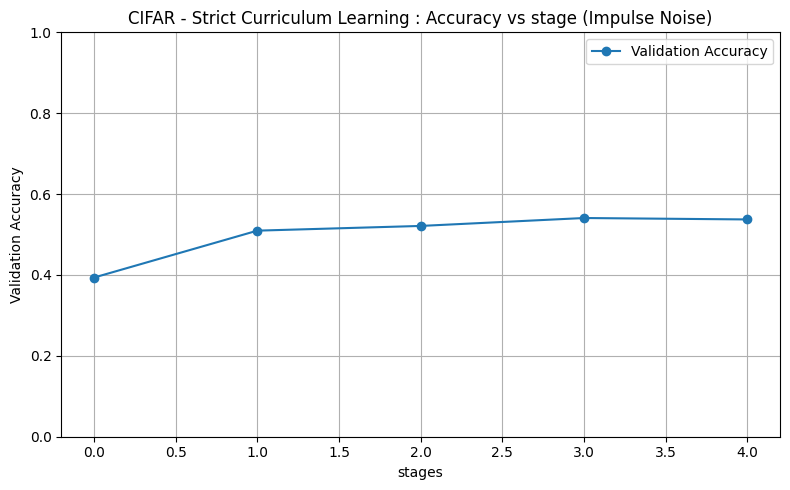

In [212]:
plot_validation_accuracy(
    range(num_stages_strict_cl_impulse),
    res_strict_cl_impulse['val_accs'],
    x_label="stages",
    title="CIFAR - Strict Curriculum Learning : Accuracy vs stage (Impulse Noise)",
    convergence_epoch=res_strict_cl_impulse["convergence_idx"])

### (2) Self-Paced Learning

In [214]:
num_stage_spl_impulse = 6
num_epochs_per_stage_spl_impulse = 3

res_spl_impulse = run_self_paced_training(
    SmallCNN,
    train_data,
    val_loader,
    test_loader,
    num_stages=num_stage_spl_impulse,
    epochs_per_stage=num_epochs_per_stage_spl_impulse,
    lambda_start = 2.25,
    lambda_step = 5,
    epsilon=epsilon,
    device="mps" if torch.backends.mps.is_available() else "cpu"
)

Stage 1/6 (lambda=2.2500): 9665/43200 samples selected
    Train Loss: 0.6361, Val Acc: 0.1638
Stage 2/6 (lambda=7.2500): 12956/43200 samples selected
    Train Loss: 0.7069, Val Acc: 0.1923
Stage 3/6 (lambda=12.2500): 18708/43200 samples selected
    Train Loss: 0.6763, Val Acc: 0.3344
Stage 4/6 (lambda=17.2500): 38128/43200 samples selected
    Train Loss: 0.8491, Val Acc: 0.5244
Stage 5/6 (lambda=22.2500): 43125/43200 samples selected
    Train Loss: 0.6951, Val Acc: 0.5621
Stage 6/6 (lambda=27.2500): 43200/43200 samples selected
    Train Loss: 0.4622, Val Acc: 0.5537

Final Test Accuracy: 0.5523


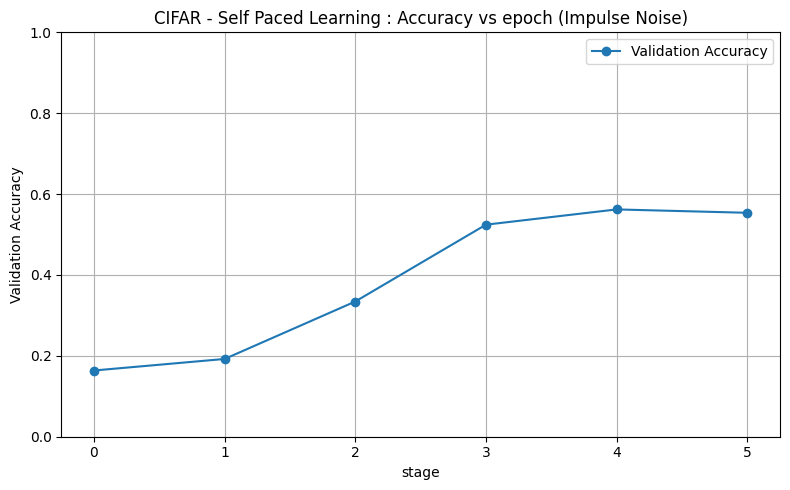

In [215]:
plot_validation_accuracy(
    range(num_stage_spl_impulse),
    res_spl_impulse["val_accs"],
    x_label="stage",
    title="CIFAR - Self Paced Learning : Accuracy vs epoch (Impulse Noise)",
    convergence_epoch=res_spl_impulse["convergence_idx"])

### (3) Hard-Example Mining

In [216]:
selector_meta_hard_impulse = {"noise_levels": noise_levels_train}
num_epochs_hard_impulse = 10

res_hard_impulse = run_hard_example_training(
    SmallCNN,
    train_data,
    val_loader,
    test_loader,
    noise_level_hard_selector,
    selector_meta_hard_impulse,
    hard_threshold=3,
    epochs=num_epochs_hard_impulse,
    epsilon=epsilon,
    device="mps" if torch.backends.mps.is_available() else "cpu"
)


Using 17280 hard examples...
    Epoch 1/10 - Train Loss: 1.9058 - Val Accuracy: 0.3613
    Epoch 2/10 - Train Loss: 1.6167 - Val Accuracy: 0.4294
    Epoch 3/10 - Train Loss: 1.4742 - Val Accuracy: 0.4579
    Epoch 4/10 - Train Loss: 1.3688 - Val Accuracy: 0.4831
    Epoch 5/10 - Train Loss: 1.2980 - Val Accuracy: 0.4748
    Epoch 6/10 - Train Loss: 1.2123 - Val Accuracy: 0.5108
    Epoch 7/10 - Train Loss: 1.1328 - Val Accuracy: 0.5204
------------ The model has converged at epoch 7 ------------

Final Test Accuracy: 0.5154


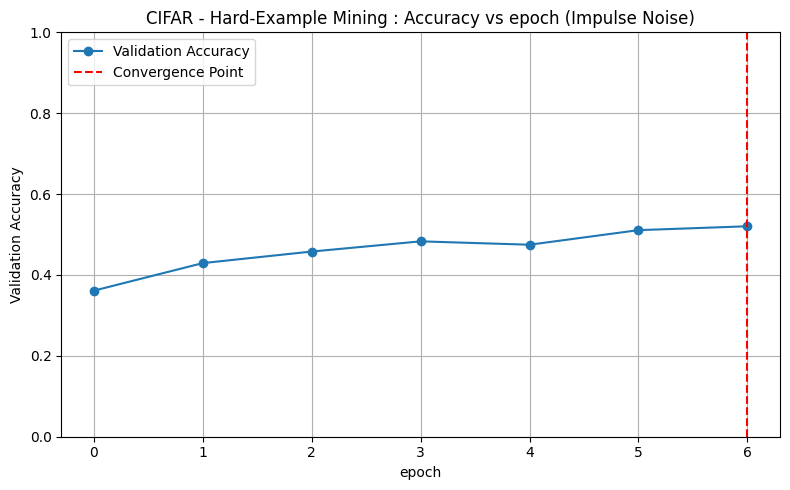

In [218]:
plot_validation_accuracy(
    range(res_hard_impulse["convergence_idx"]+1),
    res_hard_impulse["val_accs"],
    x_label="epoch",
    title="CIFAR - Hard-Example Mining : Accuracy vs epoch (Impulse Noise)",
    convergence_epoch=res_hard_impulse["convergence_idx"])

### (4) Reverse Curriculum Learning

#### (4.1) Cumulative Reverse Curriculum Learning

In [219]:
num_stage_rcl_cum_impulse = 5
num_epochs_per_stage_rcl_cum_impulse = 10

res_cum_rcl_impulse = run_reverse_curriculum_training(
    SmallCNN,
    train_data,
    val_loader,
    test_loader,
    stage_selector_fn=reverse_noise_level_cum_selector,
    selector_meta={"noise_levels": noise_levels_train},
    num_stages=num_stage_rcl_cum_impulse,
    epochs_per_stage=num_epochs_per_stage_rcl_cum_impulse,
    device="mps" if torch.backends.mps.is_available() else "cpu",
    epsilon=epsilon
)


Stage 1/5 (reverse): Using 8640 samples
    Epoch 1/10 - Train Loss: 2.0546
    Epoch 2/10 - Train Loss: 1.8217
    Epoch 3/10 - Train Loss: 1.6911
    Epoch 4/10 - Train Loss: 1.5788
    Epoch 5/10 - Train Loss: 1.5139
    Epoch 6/10 - Train Loss: 1.4232
    Epoch 7/10 - Train Loss: 1.3614
    Epoch 8/10 - Train Loss: 1.3040
    Epoch 9/10 - Train Loss: 1.2326
    Epoch 10/10 - Train Loss: 1.1638
Validation accuracy : 0.4454

Stage 2/5 (reverse): Using 17280 samples
    Epoch 1/10 - Train Loss: 1.2935
    Epoch 2/10 - Train Loss: 1.2122
    Epoch 3/10 - Train Loss: 1.1313
    Epoch 4/10 - Train Loss: 1.0640
    Epoch 5/10 - Train Loss: 0.9900
    Epoch 6/10 - Train Loss: 0.9159
    Epoch 7/10 - Train Loss: 0.8393
    Epoch 8/10 - Train Loss: 0.7709
    Epoch 9/10 - Train Loss: 0.6889
    Epoch 10/10 - Train Loss: 0.6117
Validation accuracy : 0.5112

Stage 3/5 (reverse): Using 25920 samples
    Epoch 1/10 - Train Loss: 0.9067
    Epoch 2/10 - Train Loss: 0.8107
    Epoch 3/10 - Train 

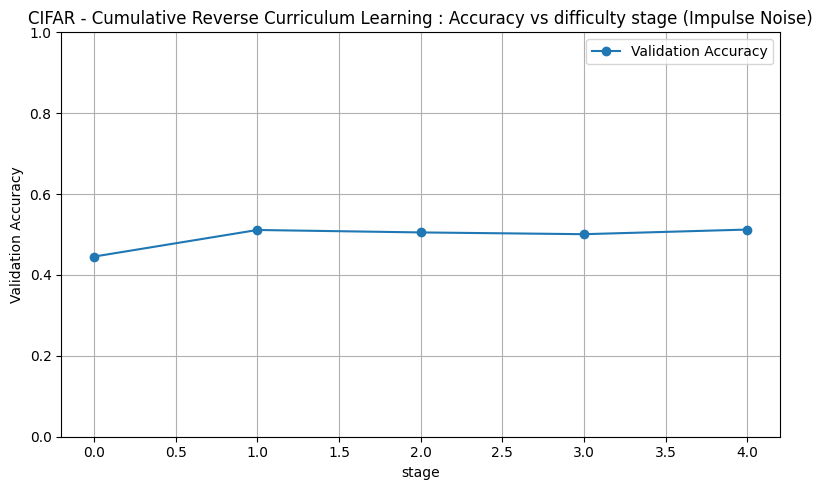

In [220]:
plot_validation_accuracy(
    list(range(num_stage_rcl_cum_impulse)),
    res_cum_rcl_impulse["val_accs"],
    x_label="stage",
    title="CIFAR - Cumulative Reverse Curriculum Learning : Accuracy vs difficulty stage (Impulse Noise)",
    convergence_epoch=res_cum_rcl_impulse["convergence_idx"])

#### (4.2) Strict Reverse Curriculum Learning

In [221]:
num_stage_strict_rcl_impulse = 5
num_epochs_per_stage_strict_rcl_impulse = 10

res_strict_rcl_impulse = run_reverse_curriculum_training(
    SmallCNN,
    train_data,
    val_loader,
    test_loader,
    stage_selector_fn=noise_level_strict_selector,
    selector_meta={"noise_levels": noise_levels_train},
    num_stages=num_stage_strict_rcl_impulse,
    epochs_per_stage=num_epochs_per_stage_strict_rcl_impulse,
    device="mps" if torch.backends.mps.is_available() else "cpu",
    epsilon=epsilon
)


Stage 1/5 (reverse): Using 8640 samples
    Epoch 1/10 - Train Loss: 2.0344
    Epoch 2/10 - Train Loss: 1.7287
    Epoch 3/10 - Train Loss: 1.5676
    Epoch 4/10 - Train Loss: 1.4739
    Epoch 5/10 - Train Loss: 1.3780
    Epoch 6/10 - Train Loss: 1.3122
    Epoch 7/10 - Train Loss: 1.2490
    Epoch 8/10 - Train Loss: 1.1581
    Epoch 9/10 - Train Loss: 1.0694
    Epoch 10/10 - Train Loss: 0.9870
Validation accuracy : 0.4612

Stage 2/5 (reverse): Using 8640 samples
    Epoch 1/10 - Train Loss: 1.4300
    Epoch 2/10 - Train Loss: 1.2929
    Epoch 3/10 - Train Loss: 1.1887
    Epoch 4/10 - Train Loss: 1.0997
    Epoch 5/10 - Train Loss: 1.0062
    Epoch 6/10 - Train Loss: 0.9014
    Epoch 7/10 - Train Loss: 0.7987
    Epoch 8/10 - Train Loss: 0.6857
    Epoch 9/10 - Train Loss: 0.5720
    Epoch 10/10 - Train Loss: 0.4662
Validation accuracy : 0.4983

Stage 3/5 (reverse): Using 8640 samples
    Epoch 1/10 - Train Loss: 1.4353
    Epoch 2/10 - Train Loss: 1.1869
    Epoch 3/10 - Train Lo

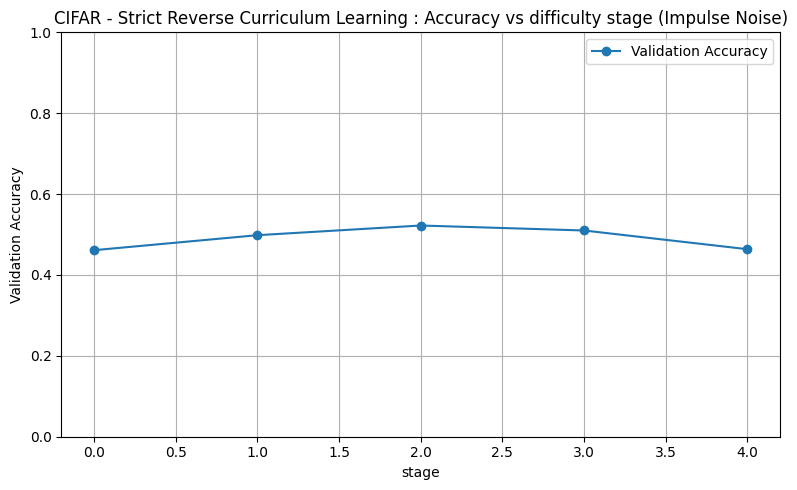

In [222]:
plot_validation_accuracy(
    list(range(num_stage_strict_rcl_impulse)),
    res_strict_rcl_impulse["val_accs"],
    x_label="stage",
    title="CIFAR - Strict Reverse Curriculum Learning : Accuracy vs difficulty stage (Impulse Noise)",
    convergence_epoch=res_strict_rcl_impulse["convergence_idx"])

### (5) Stratified Monte-Carlo Sampling

**Stratified Monte Carlo Sampling** is a variance reduction technique where the input space is divided into distinct strata (subregions), and samples are drawn from each stratum. This ensures more uniform coverage of the space compared to standard Monte Carlo sampling, leading to more accurate and stable estimates with fewer samples.

In [223]:
num_stages_smc_impulse = 5
num_epochs_per_stage_smc_impulse = 10

res_smc_impulse = run_stratified_monte_carlo_training(
    SmallCNN,
    train_data,
    val_loader,
    test_loader,
    noise_levels_train,
    num_stages=num_stages_smc_impulse,
    epochs_per_stage=num_epochs_per_stage_smc_impulse,
    epsilon=epsilon,
    device="mps" if torch.backends.mps.is_available() else "cpu",
)


Stage 1/5: Sampling from stage level = 0
  Using 3456 samples for stage 1
    Epoch 1/10: Train Loss = 2.1626
    Epoch 2/10: Train Loss = 1.8777
    Epoch 3/10: Train Loss = 1.6988
    Epoch 4/10: Train Loss = 1.5475
    Epoch 5/10: Train Loss = 1.4328
    Epoch 6/10: Train Loss = 1.3354
    Epoch 7/10: Train Loss = 1.2578
    Epoch 8/10: Train Loss = 1.1766
    Epoch 9/10: Train Loss = 1.0875
    Epoch 10/10: Train Loss = 1.0341
  Validation Loss: 1.5689, Accuracy: 0.4573

Stage 2/5: Sampling from stage level = 1
  Using 3456 samples for stage 2
    Epoch 1/10: Train Loss = 1.4525
    Epoch 2/10: Train Loss = 1.2726
    Epoch 3/10: Train Loss = 1.1648
    Epoch 4/10: Train Loss = 1.0947
    Epoch 5/10: Train Loss = 0.9964
    Epoch 6/10: Train Loss = 0.9149
    Epoch 7/10: Train Loss = 0.8180
    Epoch 8/10: Train Loss = 0.7399
    Epoch 9/10: Train Loss = 0.6728
    Epoch 10/10: Train Loss = 0.5660
  Validation Loss: 1.6561, Accuracy: 0.4671

Stage 3/5: Sampling from stage level = 

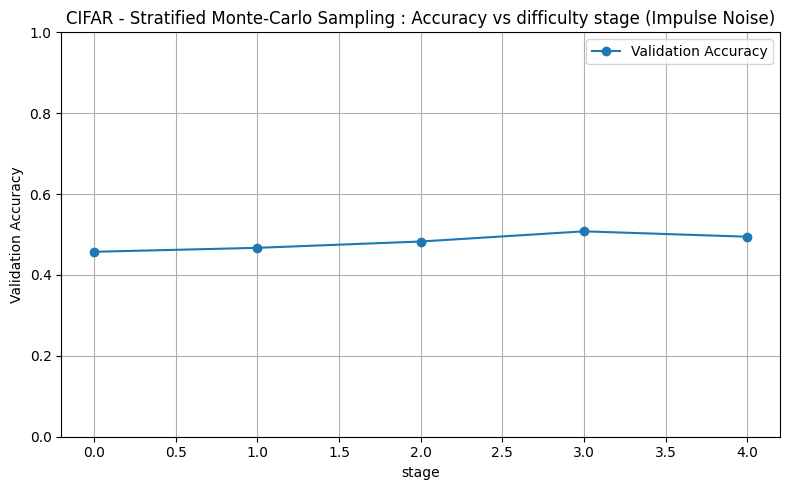

In [224]:
plot_validation_accuracy(
    range(num_stages_smc_impulse),
    res_smc_impulse["val_accs"],
    x_label="stage",
    title="CIFAR - Stratified Monte-Carlo Sampling : Accuracy vs difficulty stage (Impulse Noise)",
    convergence_epoch=res_smc_impulse["convergence_idx"])

## Final Results

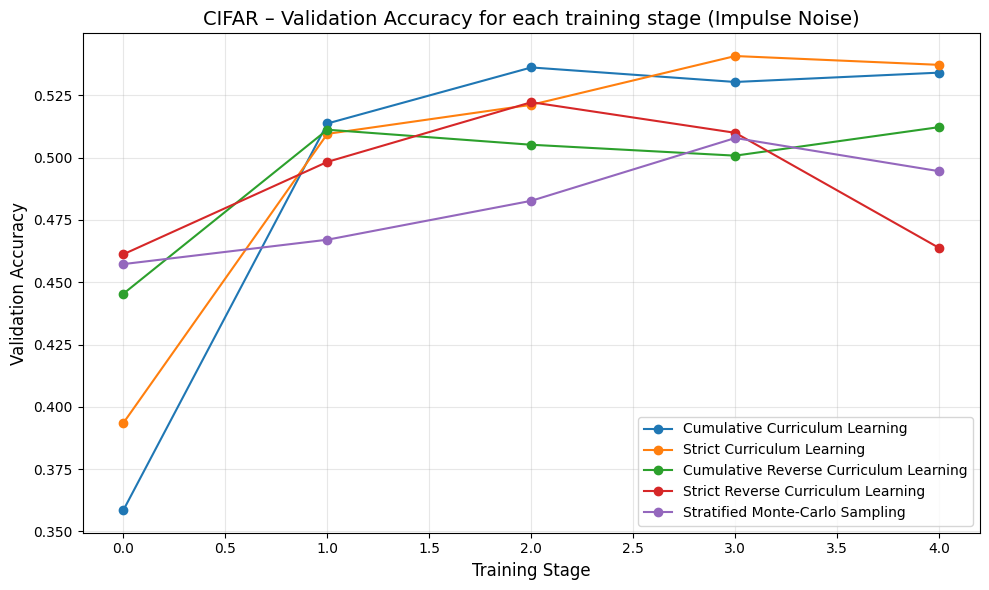

In [234]:
plot_multi_curves(
    range(5),
    res_cum_cl_impulse['val_accs'],
    res_strict_cl_impulse['val_accs'],
    res_cum_rcl_impulse['val_accs'],
    res_strict_rcl_impulse['val_accs'],
    res_smc_impulse['val_accs'],
    labels=[
        "Cumulative Curriculum Learning",
        "Strict Curriculum Learning",
        "Cumulative Reverse Curriculum Learning",
        "Strict Reverse Curriculum Learning",
        "Stratified Monte-Carlo Sampling"
    ],
    title="CIFAR – Validation Accuracy for each training stage (Impulse Noise)",
    xlabel="Training Stage",
    ylabel="Validation Accuracy",
    markers=["o", "o", "o", "o", "o"],
    linestyles=["-", "-", "-", "-", "-"],
)

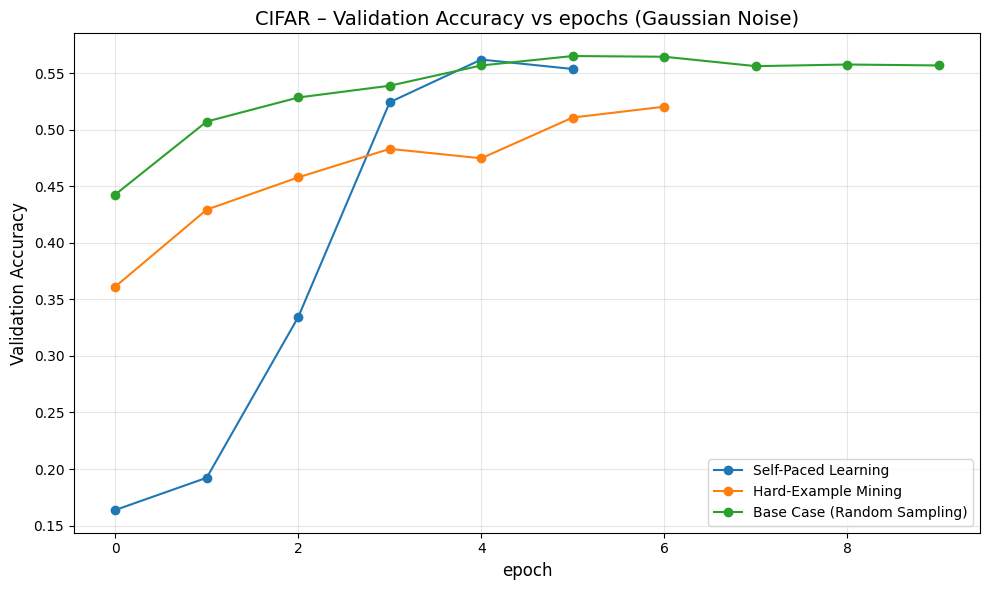

In [274]:
#hard-example,self-paced,base case
num_epochs=10
plot_multi_curves(
    range(num_epochs),
    pad_to_length(res_spl_impulse['val_accs'], num_epochs),
    pad_to_length(res_hard_impulse['val_accs'], num_epochs),
    pad_to_length(stage_accs_impulse, num_epochs),
    labels=[
        "Self-Paced Learning",
        "Hard-Example Mining",
        "Base Case (Random Sampling)"
    ],
    title="CIFAR – Validation Accuracy vs epochs (Gaussian Noise)",
    xlabel="epoch",
    ylabel="Validation Accuracy",
    markers=["o", "o", "o"],
    linestyles=["-", "-", "-"],
)